### Install packages

In [114]:
# work with data
import numpy as np
import pandas as pd
import h5pyd
import yaml
import os
import statsmodels.api as sm
import math

# work with geospatial
import geopandas as gpd
from scipy.interpolate import griddata
import scipy.stats as stats
from pyproj import Proj, Transformer
from scipy.spatial import cKDTree
import restapi
import geojson
from shapely.geometry.point import Point

# optimization
import gurobipy as gp
from gurobipy import GRB

# visualization
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar

# work with time
import pytz
import dateutil
from datetime import datetime, timezone

### Get geometries

In [18]:
# transform centroid to lat and lon
transformer = Transformer.from_crs(5070, 4326)
transformer_inv = Transformer.from_crs(4326, 5070)

In [56]:
# Arizona and Virginia shapefiles

us_states = gpd.read_file('data/data_siting/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
us_states['in_AZ_VA'] = us_states['NAME'].map(lambda x: (x == 'Arizona') or (x == 'Virginia'))
az_va = us_states[us_states['in_AZ_VA']]
az_va.to_crs("EPSG:5070", inplace=True) # we use EPSG 5070 to get more accurate area measurements. https://epsg.io/5070-1252

# water basins shapefile
# see page 2 for explanation of what HUC8 subbasins are: https://pubs.usgs.gov/tm/11/a3/pdf/tm11-a3_5ed.pdf

huc_subbasins = gpd.read_file('data/data_siting/HUC8_CONUS/HUC8_US.shp') # read in subbasins
huc_subbasins['in_AZ'] = huc_subbasins['STATES'].map(lambda x: 'AZ' in x)
huc_subbasins['in_VA'] = huc_subbasins['STATES'].map(lambda x: 'VA' in x)
huc_subbasins['in_AZ_VA'] = huc_subbasins['STATES'].map(lambda x: ('AZ' in x) or ('VA' in x))
huc_subbasins = huc_subbasins[huc_subbasins['in_AZ_VA']]
huc_subbasins.to_crs("EPSG:5070", inplace=True)

# also, in case we want centroid:
huc_subbasins['centroid'] = huc_subbasins.to_crs("+proj=cea").centroid.to_crs(huc_subbasins.crs)
huc_subbasins['centroid_lat_lon'] = huc_subbasins['centroid'].map(lambda pt: transformer.transform(pt.x, pt.y))


# read in US counties
us_counties = gpd.read_file('data/data_siting/cb_2018_us_county_500k/cb_2018_us_county_500k.shp') # read in counties
us_counties['in_AZ_VA'] = us_counties['STATEFP'].map(lambda x: (x == '04') or (x == '51')) # reference: https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm
us_counties = us_counties[us_counties['in_AZ_VA']] # filter to arizona
us_counties.to_crs("EPSG:5070", inplace=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [57]:
# data values for HUC8 regions generated from the paper by Abu Bakar Siddik et al 2021: https://iopscience.iop.org/article/10.1088/1748-9326/abfba1?_sp=b48260d8-0a7b-4784-9d4b-0e1ac60ee727
water_carbon = pd.read_excel("data/data_siting/DC_footprint/SI_XLS/Results.xlsx", sheet_name="Table 3", skiprows=1)

water_carbon['HUC8_str'] = water_carbon['HUC8'].map(lambda x: ''.join(['0']*(8-len(str(x)))) + str(x))

# filter to only HUC rows
water_carbon['not_nan'] = ~water_carbon['WSF_1MW_DC'].isna()
water_carbon = water_carbon[water_carbon['not_nan']]

# now merge with the paper HUC data
huc_subbasins = huc_subbasins.merge(water_carbon, how="inner", left_on="HUC8", right_on="HUC8_str")
huc_subbasins = gpd.clip(huc_subbasins, az_va.union_all())

### Solar and Wind Data Collection

In [6]:
# access NSRDB stuff: https://github.com/NREL/hsds-examples/tree/master

# takes around a minute to run 

solar = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2013.h5")
meta = pd.DataFrame(solar['meta'][...])

In [ ]:
# find the nearest timeseries
# code source: https://github.com/NREL/hsds-examples/blob/master/notebooks/03_NSRDB_introduction.ipynb
dset_coords = solar['coordinates'][...]
tree = cKDTree(dset_coords)

def nearest_site_solar(tree, lat_coord, lon_coord):
    """ 
    Find the nearest site in the solar dataset.

    Parameters
    ----------
        tree: scipy.spatial.cKDTree
            Lookup tree for nearest neighbor
        lat_coord: float
            Latitude
        lon_coord: float
            Longitude

    Returns
    -------
        Index of closest point in the solar dataset
    """

    lat_lon = np.array([lat_coord, lon_coord])
    _, pos = tree.query(lat_lon)
    return pos

In [ ]:
# collect DNI, DHI, GHI at every point
# takes around 10 min to run

dni_data = solar['dni']
dhi_data = solar['dhi']
ghi_data = solar['ghi']

dni_subbasins = np.zeros((dni_data.shape[0], huc_subbasins.shape[0])) # rows: timestamps, # columns: locations
dhi_subbasins = np.zeros((dhi_data.shape[0], huc_subbasins.shape[0])) # rows: timestamps, # columns: locations
ghi_subbasins = np.zeros((ghi_data.shape[0], huc_subbasins.shape[0])) # rows: timestamps, # columns: locations

# for each arizona subbasin centroid, get the solar data of the closest point
for idx, centroid_lat_lon in enumerate(huc_subbasins['centroid_lat_lon']):
    if np.sum(ghi_subbasins[:, idx]) == 0:
        centroid_idx = nearest_site_solar(tree, centroid_lat_lon[0], centroid_lat_lon[1])

        dni_tseries = dni_data[:, centroid_idx] / dni_data.attrs['psm_scale_factor']
        dhi_tseries = dhi_data[:, centroid_idx] / dhi_data.attrs['psm_scale_factor']
        ghi_tseries = ghi_data[:, centroid_idx] / ghi_data.attrs['psm_scale_factor'] # units: W/m^2. https://nsrdb.nrel.gov/data-sets/us-data

        dni_subbasins[:, idx] = dni_tseries
        dhi_subbasins[:, idx] = dhi_tseries
        ghi_subbasins[:, idx] = ghi_tseries

# ghi_subbasins = shift_from_utc(ghi_subbasins, 7, 0.5) # shift to Arizona time. 7 hours delay

In [15]:
# timestamp

# convert timestamps from UTC to local time: https://www.geeksforgeeks.org/how-to-convert-date-and-time-with-different-timezones-in-python/, https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568

time_index = pd.to_datetime(solar['time_index'][...].astype(str))

time_index = time_index.tz_localize(pytz.utc)

# time_index = time_index.map(lambda x: x.astimezone(AZ_time)) # change from UTC to Arizona time


# time_index = shift_from_utc(time_index, 7, 0.5)

In [16]:
# calculate the beta angle at each point

AZ_time = pytz.timezone('America/Phoenix')
VA_time = pytz.timezone('America/New_York')

beta_angles = np.zeros((time_index.shape[0], huc_subbasins.shape[0]))

for idx, (_, row) in enumerate(huc_subbasins.iterrows()):
    centroid_lat, centroid_lon = row['centroid_lat_lon']

    # get local clock time
    if 'AZ' in row['STATES']: 
        curr_times = time_index.map(lambda x: x.astimezone(AZ_time))

        # local meridian is 105
        longitude_add = 4*(105 - centroid_lon)
    elif  'VA' in row['STATES']:
        curr_times = time_index.map(lambda x: x.astimezone(VA_time))

        # local meridian is 75
        longitude_add = 4*(75 - centroid_lon)

    curr_betas = []

    for stamp in curr_times:
        # compute solar time
        hour = stamp.timetuple()[3] + (1/60)*stamp.timetuple()[4]
        day = stamp.timetuple()[-2]
               
        # adding factor: equation of time
        time_input = (360/364)*(day-81)
        E = 9.87*np.sin(2*time_input*(2*np.pi/360)) - 7.53*np.cos(time_input*(2*np.pi/360)) - 1.5*np.sin(time_input*(2*np.pi/360))
        
        # get the hour angle
        H = 15*(12 - (hour + longitude_add/60 + E/60))
        
        declination = 23.45*np.sin((360/365)*(day - 81)*(2*np.pi/360))

        sin_beta = np.cos(centroid_lat*(2*np.pi/360))*np.cos(declination*(2*np.pi/360))*np.cos(H*(2*np.pi/360)) + np.sin(centroid_lat*(2*np.pi/360))*np.sin(declination*(2*np.pi/360))

        curr_betas.append(np.arcsin(sin_beta))

    beta_angles[:, idx] = np.array(curr_betas)*(360/(2*np.pi))

In [17]:
# now, we're ready to calculate solar energy production

rho = 0.2 # a typical value for ground reflectivity
total_insolation = dni_subbasins + dhi_subbasins*((1+np.cos((90-beta_angles)*(2*np.pi/360)))/2) + ghi_subbasins*rho*((1-np.cos((90-beta_angles)*(2*np.pi/360)))/2)

In [18]:
# max_insolation = np.max(total_insolation) # obtain max irradiance

# and then aggregate the insolation values into days
total_insolation = total_insolation.reshape((ghi_data.shape[0]//48, 48, huc_subbasins.shape[0])) # note grouping by 48, because we are in half hour intervals

total_insolation = total_insolation.sum(axis=1)*0.5 # W/(m^2 * day). Don't forget time step is a half hour

In [ ]:
# save solar data
insolation_df = pd.DataFrame(total_insolation)
insolation_df.to_csv("data/data_siting/insolation_AZ_VA.csv") # W/(m^2 * day)

In [20]:
# now think about generation per watt of capacity, per day
insolation_df = pd.read_csv("data/data_siting/insolation_AZ_VA.csv", index_col=0)
# insolation_df_per_watt = insolation_df/max_GHI
insolation_df_per_watt = insolation_df/1000 # we divide by 1000 to get a per-watt measurement. https://www.greenlancer.com/post/solar-panel-wattage-output-explained#:~:text=A%20solar%20panel%20rating%20measures,sunlight%20at%201000W%2Fsquare%20meters.
insolation_df_per_watt.to_csv("data/data_siting/insolation_AZ_VA_per_watt.csv")

In [ ]:
# solar capacity computation: oof I will do this later. just assume 21% efficiency for now. https://css.umich.edu/publications/factsheets/energy/solar-pv-energy-factsheet#:~:text=Solar%20Resources%20and%20Potential&text=PV%20conversion%20efficiency%20is%20the,that%20is%20converted%20to%20electricity.&text=Though%20the%20average%20efficiency%20of,with%20efficiencies%20near%2040%259.

# solar panel price: $2.06/W, https://www.energysage.com/local-data/solar-panel-cost/az/
# and roughly solar panels are 200 W/m^2. https://www.sunstyle.com/portfolio/square-meter-solar-family-need/#:~:text=The%20efficiency%20of%20solar%20panels,value%20of%20175%20Wp%2Fm%C2%B2.
# which means, 200W of solar panel gets you just the irradiation times 21%.
# so, 1W of solar panel gets you the irradiation times 21%/200, which is around 0.1%.
# so basically just divide the irradiance by 1000. https://www.greenlancer.com/post/solar-panel-wattage-output-explained#:~:text=A%20solar%20panel%20rating%20measures,sunlight%20at%201000W%2Fsquare%20meters.
# so, say solar panels are $412/m^2. And then we multiply the production by 21%.

In [265]:
wind = h5pyd.File("/nrel/wtk-us.h5")

# rated power
# lets try this wind turbine model GE1.5, just out of commonality. https://en.wind-turbine-models.com/turbines/565-ge-vernova-ge-1.5s
# lets say 77m height
# and 80m diameter --> regime is around 42m to 112m
# so let's take windspeed at 77m

# convert using the power curve
# https://nrel.github.io/turbine-models/DOE_GE_1.5MW_77.html
GE_power_curve = pd.read_csv('data/data_siting/DOE_GE_1.5MW_77.csv')
GE_power_curve['Power [kW]'] = GE_power_curve['Power [kW]'].map(lambda x: np.clip(x, 0, np.inf)) # don't allow negative power production

wind_speed = wind['windspeed_80m'] # start working with wind speed data

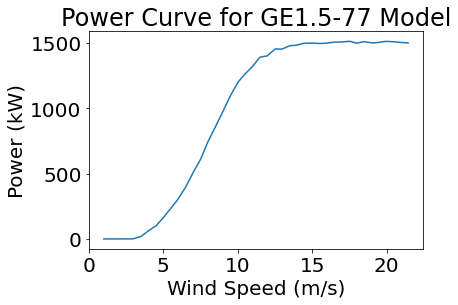

In [11]:
matplotlib.rcParams.update({'font.size': 20})

fig, ax = plt.subplots()

ax.plot(GE_power_curve['Wind Speed [m/s]'], GE_power_curve['Power [kW]'])

ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")

ax.set_title("Power Curve for GE1.5-77 Model")

fig.savefig("Figures/ge_curve.png", dpi=200, bbox_inches="tight")

In [22]:
# note: the wind data is hourly
wind_time = pd.DataFrame({'datetime': wind['datetime']})
wind_time['datetime'] = wind_time['datetime'].apply(dateutil.parser.parse)
wind_time['datetime'] = wind_time['datetime'].map(lambda x: x.replace(tzinfo=timezone.utc))

# get 2013 data when querying for specific locations, right now data is too large
# just select 2013 data
wind_time['year'] = wind_time['datetime'].map(lambda x: x.year)
wind_time = wind_time[wind_time['year'] == 2013]
indices_2013 = wind_time.index

# AZ_time = pytz.timezone('America/Phoenix')
# wind_time['datetime'] = wind_time['datetime'].map(lambda x: x.astimezone(AZ_time)) # change from UTC to Arizona time

# shift dataset to start at Arizona midnight
# wind_time = shift_from_utc(wind_time, 7, 1)

In [29]:
# code source: https://github.com/NREL/hsds-examples/blob/master/notebooks/01_WTK_introduction.ipynb
def nearest_wind_site(data, lat_index, lon_index):
    """ 
    Get nearest site with wind data to input location.

    Parameters
    ----------
        data: h5pyd._hl.dataset.Dataset
            Full dataset, for coordinates
        lat_index: float
            Latitude
        lon_index: float
            Longitude

    Returns
    -------
        Longitude and latitude index of closest point in the wind dataset.
    """

    data_coords = data['coordinates']

    # find nearby point, convert to x/y indices
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    project_lcc = Proj(projstring)
    origin_ll = reversed(data_coords[0][0]) # origin. But flip order to get lon, lat
    origin = project_lcc(*origin_ll)

    coords = (lon_index, lat_index) # note the order of lon, lat
    coords = project_lcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta] # by rounding, we just get the nearest lattice point
    return tuple(reversed(ij))

In [266]:
# convert wind to energy

with open("data/data_siting/DOE_GE_1.5MW_77.yaml", 'r') as f:
    turbine_specs = yaml.safe_load(f)
    cut_in = turbine_specs['cut_in_wind_speed']
    cut_out = turbine_specs['cut_out_wind_speed']
    rated_wind = turbine_specs['rated_wind_speed']
    rated_power = turbine_specs['rated_power']

measured_winds = GE_power_curve['Wind Speed [m/s]'].values
measured_wind_power = GE_power_curve['Power [kW]'].values

def wind_speed_to_energy(tseries):
    """ 
    Converts wind speed to energy.

    Parameters
    ----------
        tseries: np.ndarray
            Time series array of wind speed values (m/s)

    Returns
    -------
        Time series array of wind energy multiplier values (W produced, per W of capacity).
    """

    wind_measure_array = np.repeat(measured_winds.reshape(-1,1), tseries.shape[0], axis=1) # for each of the time series stamps, keep track of relation to measured wind speed

    # find the index closest to the time series
    wind_diffs = wind_measure_array - tseries
    diff_min_pos = np.argmax(wind_diffs >= 0, axis=0)

    # and then interpolate
    # if diff_min_pos = 0, either the wind speed was too low (below lowest measurement), or the wind speed was too high (above highest measurement)
    computed_power = np.where(diff_min_pos > 0, ((measured_winds[diff_min_pos] - tseries)/(measured_winds[diff_min_pos] - measured_winds[diff_min_pos-1])) * measured_wind_power[diff_min_pos-1] + ((tseries - measured_winds[diff_min_pos-1])/(measured_winds[diff_min_pos] - measured_winds[diff_min_pos - 1])) * measured_wind_power[diff_min_pos], 0)

    # divide by rated power
    computed_power /= rated_power

    # however, special cases: below cut-in, between rated and cut-out wind speed, above cut-out wind speed
    computed_power = np.where((tseries < cut_in) | (tseries > cut_out), 0, computed_power) # clip below cut-in power or above cut_out power
    computed_power = np.where((tseries > rated_wind) & (tseries < cut_out), 1, computed_power) # max out power production between rated and cut-out wind speed
    
    return computed_power

In [267]:
turbine_specs

{'name': 'DOE_GE_1.5_MW',
 'nickname': None,
 'rated_power': 1500,
 'rated_wind_speed': 14.5,
 'cut_in_wind_speed': 3.5,
 'cut_out_wind_speed': 25,
 'rotor_diameter': 77,
 'hub_height': 80,
 'drivetrain': 'Geared',
 'control': 'Pitch Regulated',
 'iec_class': 'IIa',
 'group': 'Onshore',
 'power_curve_file': 'Onshore/DOE_GE_1.5MW_77.csv',
 'manufacturer': None,
 'origin': None,
 'power_curve_type': 'theoretical',
 'rated_tsr': None,
 'reference_links': []}

In [ ]:
# get wind speeds at closest location for each of the Arizona subbasins

# takes around 5 minutes to run

wind_speed_subbasins = np.zeros((wind_time.shape[0], huc_subbasins.shape[0]))

# for each wind subbasin centroid, get wind data of closest point
for idx, centroid_lat_lon in enumerate(huc_subbasins['centroid_lat_lon']):
    if np.sum(wind_speed_subbasins[:,idx]) == 0:
        centroid_idx = nearest_wind_site(wind, centroid_lat_lon[0], centroid_lat_lon[1])
        wind_tseries = wind_speed[indices_2013, centroid_idx[0], centroid_idx[1]] # units: m/s.

        wind_speed_subbasins[:, idx] = wind_tseries

In [30]:
# intermediate save checkpoint. So we don't have to wait again
wind_speed_subbasins_df = pd.DataFrame(wind_speed_subbasins)
wind_speed_subbasins_df.to_csv("data/data_siting/wind_speed_subbasin_AZ_VA.csv")

In [31]:
# read in csv
wind_speed_subbasins_df = pd.read_csv("data/data_siting/wind_speed_subbasin_AZ_VA.csv", index_col=0)
wind_speed_subbasins_np = wind_speed_subbasins_df.values

In [32]:
# convert wind speed data to wind power

wind_power_subbasins = np.zeros(wind_speed_subbasins_np.shape)

for idx in range(wind_speed_subbasins_np.shape[1]):
    curr_tseries = wind_speed_subbasins_np[:, idx]
    curr_power_tseries = wind_speed_to_energy(curr_tseries)
    wind_power_subbasins[:, idx] = curr_power_tseries # this is in units of how much power you get per watt installed

# don't forget to shift dataset to Arizona time
# wind_power_subbasins = shift_from_utc(wind_power_subbasins, 7, 1)

In [33]:
# save the data
wind_power_subbasins_df = pd.DataFrame(wind_power_subbasins)
wind_power_subbasins_df.to_csv("data/data_siting/wind_power_per_watt_hourly.csv")

In [34]:
# aggregate into days
wind_power_subbasins_np = pd.read_csv("data/data_siting/wind_power_per_watt_hourly.csv", index_col=0).values
wind_power_subbasins_np = wind_power_subbasins_np.reshape((wind_power_subbasins_np.shape[0]//24, 24, wind_power_subbasins_np.shape[1]))
wind_power_subbasins_np = np.sum(wind_power_subbasins_np, axis=1) # no need for multiplier. because data is hourly already.

# save new data
wind_power_subbasins_daily_df = pd.DataFrame(wind_power_subbasins_np)
wind_power_subbasins_daily_df.to_csv("data/data_siting/wind_power_per_watt_daily.csv")

In [ ]:
# wind calculations:
# price: let's say $1500/kW --> $1,500,000/MW. https://www.energy.gov/eere/wind/articles/land-based-wind-market-report-2022-edition

### Gather data for HUC8 level

In [254]:
# virginia data centers
if not os.path.exists("data/data_siting/virginia_DC.geojson"):
    virginia_data = "https://services3.arcgis.com/mTaShYKffyWc5uRb/ArcGIS/rest/services/Data_Centers_Virginia/FeatureServer/19"
    virginia_DC = restapi.FeatureLayer(virginia_data)

    cursor = restapi.SearchCursor(virginia_DC, fields=['OBJECTID', 'PEC_ID', 'Locality', 'Name', 'Parcel_ID', 'Acres', 'Building_Sq_Ft', 'MW_reported', 'Build_Status', 'Notes', 'Lat', 'Long', 'Lat1'], where="1=1")

    va_dc_geojson = geojson.FeatureCollection(cursor.featureSet.features)

    with open("data/data_siting/virginia_DC.geojson", "w") as f:
        geojson.dump(va_dc_geojson, f)

virginia_DC_df = gpd.read_file("data/data_siting/virginia_DC.geojson")
virginia_DC_df = virginia_DC_df[virginia_DC_df['Build_Status'] == 'Existing'] # only look at existing data centers
virginia_DC_df.to_crs("EPSG:5070", inplace=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


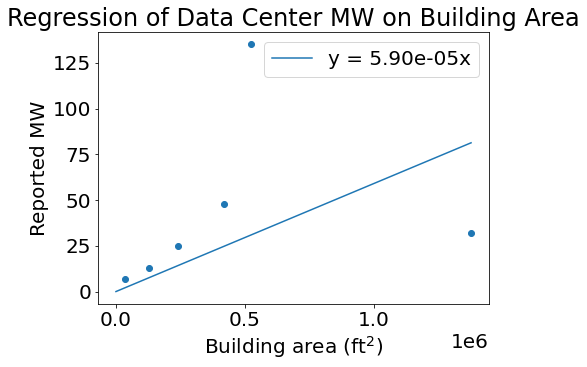

In [263]:
# let's not use this regression for now, due to relative scarcity of data points.

# estimate MW/sq ft: https://www.datacenterknowledge.com/energy-power-supply/data-center-power-fueling-the-digital-revolution. 
# approximately 1MW/5000 sq ft.
virginia_DC_df_filter = virginia_DC_df[~virginia_DC_df['MW_reported'].isna()]
virginia_DC_df_filter['Building_Sq_Ft'] = virginia_DC_df_filter['Building_Sq_Ft'].map(lambda x: float(x.replace(',', '')))

# https://stackoverflow.com/questions/25289122/scipy-linregress-computing-only-scaling-slope-parameter-with-intercept-fixed-at
model = sm.OLS(virginia_DC_df_filter['MW_reported'], virginia_DC_df_filter['Building_Sq_Ft'])
results = model.fit()
MW_sq_ft = results.params.values[0]


matplotlib.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(virginia_DC_df_filter['Building_Sq_Ft'], virginia_DC_df_filter['MW_reported'])
ax.set_xlabel(r"Building area (ft$^2$)")
ax.set_ylabel(r"Reported MW")
ax.set_title("Regression of Data Center MW on Building Area")

ax.plot(np.linspace(0,1376853.0,100), MW_sq_ft*np.linspace(0,1376853.0,100), label=f"y = {MW_sq_ft:.2e}x")
ax.legend()

fig.savefig("Figures/mw_area_regression.png", dpi=200, bbox_inches="tight")

In [59]:
subbasin_load_dict = dict()

DC_load_list = []

# filter out data centers with no building square feet
virginia_DC_df = virginia_DC_df[~virginia_DC_df['Building_Sq_Ft'].isna()]

# estimation of data center load for virginia subbasins
for idx, subbasin in huc_subbasins.iterrows():
    intersect = virginia_DC_df.intersection(subbasin['geometry'])
    contained = ~intersect.is_empty
    curr_load = np.sum(virginia_DC_df[contained]['Building_Sq_Ft'].apply(lambda x: float(x.replace(',', '')))) * MW_sq_ft # multiply by 1/5000
    DC_load_list.append(curr_load)

In [60]:
# estimations of existing data centers: https://www.datacentermap.com/
# power of existing data centers? Unclear. https://baxtel.com/data-center/phoenix
# well, in total there is around 602.8 MW in the Phoenix area. https://azbigmedia.com/real-estate/phoenix-ranks-4th-among-north-american-data-center-markets/
# and, in the Phoenix area there are 124 data centers. https://www.datacentermap.com/usa/arizona/
# so, let's say on average, each existing data center takes on 5 MW of load.

# existing inventory HUC8
# 15050301: 6
# 15050302: 2
# 15050303: 4 (from Eloy) 
# 15050100: 17 (from Mesa airport AZA) 13 (from Chandler airport CHD) 4 (from Gilbert)
# 15060106: 2 (from Mesa) 25 (from Phoenix airport and Scottsdale) 2 (from upper Scottsdale)
# 15070102: 6 (from Deer Valley) 40 (from Litchfield park airport)
# 15070103: 1 (from Buckeye/Arlington)


# totals (done by hand, because data lies behind paywalls):
# 15050301: 6
# 15050302: 2
# 15050303: 4
# 15050100: 34
# 15060106: 29
# 15070102: 46
# 15070103: 1

existing_data_centers = {
    15050301: 6,
    15050302: 2,
    15050303: 4,
    15050100: 34,
    15060106: 29,
    15070102: 46,
    15070103: 1
}

huc_subbasins['existing_MW'] = huc_subbasins['HUC8_y'].map(lambda x: existing_data_centers.get(x, 0)*5) # fill in Arizona

az_values = huc_subbasins['existing_MW'].values

# merging in virginia values
all_values = np.max([az_values, DC_load_list], axis=0)
huc_subbasins['existing_MW'] = all_values

In [62]:
# electricity prices

# ARIZONA
# https://www.energysage.com/local-data/electricity-cost/az/
# cochise county: 16 cents/kwh
# coconino county: 15 cents/kwh
# gila county: 20 cents/kwh
# la paz county: 15 cents/kwh
# maricopa county: 15 cents/kwh
# mohave county: 18 cents/kwh
# navajo county: 15 cents/kwh
# pima county: 18 cents/kwh
# pinal county: 16 cents/kwh
# yavapai county: 15 cents/kwh
# yuma county: 15 cents/kwh

# VIRGINIA
# https://www.energysage.com/local-data/electricity-cost/va/
# albermarle county: 15 cents/kwh
# alexandria (city) county: 16 cents/kwh
# amherst county: 18 cents/kwh
# arlington county: 15 cents/kwh
# floyd county: 18 cents/kwh
# fluvanna county: 16 cents/kwh
# franklin county: 15 cents/kwh
# frederick county: 15 cents/kwh
# manassas park (city) county: 14 cents/kwh
# martinsville (city) county: 15 cents/kwh
# mathews county: 12 cents/kwh
# mecklenburg county: 10 cents/kwh
# roanoke county: 17 cents/kwh
# rockbridge county: 15 cents/kwh
# rockingham county: 14 cents/kwh
# russell county: 17 cents/kwh

# units: cents/kwh
elec_price_dict = {'Cochise': 16, 'Coconino': 15, 'Gila': 20, 'La Paz': 15, 'Maricopa': 15, 'Mohave': 18, 
                   'Navajo': 15, 'Pima': 18, 'Pinal': 16, 'Yavapai': 15, 'Yuma': 15,
                   'Albermarle': 15, 'Alexandria': 16, 'Amherst': 18, 'Arlington': 15, 'Floyd': 18,
                   'Fluvanna': 16, 'Franklin': 15, 'Frederick': 15, 'Manassas Park': 14,
                   'Martinsville': 15, 'Mathews': 12, 'Mecklenburg': 10, 'Roanoke': 15, 'Rockingham': 14,
                   'Russell': 17}

# new units: dollars/mw = cents/kwh * (0.01 dollar/1 cent) * (1000 kwh/1 mw)
elec_price_dict = {k: 10*v for k, v in elec_price_dict.items()}

has_elec_price = set(elec_price_dict.keys())
num_elec_price = len(has_elec_price)

# find counties with electricity price data
us_counties['has_elec_rate'] = us_counties['NAME'].map(lambda x: x in has_elec_price)
us_counties_elec_price = us_counties[us_counties['has_elec_rate']]
us_counties_elec_price['elec_rate'] = us_counties_elec_price['NAME'].map(lambda x: elec_price_dict[x])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [63]:
# TODO move to a Python utils file

class resolve_regions:
    """ 
    Converts one subdivision of space (e.g., county) into another subdivision of space (e.g., HUC8.)

    Averages out value of interest according to amount of overlap with the first subdivision of space, or the 
    closest region. 
    """

    def __init__(self, from_df, to_df, value_col, id_row):
        """ 
        Init method for the class resolve_regions.

        Parameters
        ----------
            from_df: gpd.GeoDataFrame
                Dataframe to convert from
            to_df: gpd.GeoDataFrame
                Dataframe to convert to
            value_col: string
                Name of column with values of interest
            id_row: string
                Name of column with unique identifiers, in to_df
        """

        self.from_df = from_df
        self.to_df = to_df
        self.value_col = value_col
        self.id_row = id_row

# TODO: currently this only handles average. We can also functionalize it to handle other functions.
    def weighted_computation(self, id):
        """ 
        Perform the weighted average computation for the output row with identification id.

        Parameters
        ----------
            id: string
                Unique ID for the output row
        """

        to_geometry = self.to_df[self.to_df[self.id_row] == id]['geometry'].iloc[0] # extract geometry of to_df
        from_to_intersect = self.from_df['geometry'].intersection(to_geometry) # obtain intersections

        area_sum = np.sum(from_to_intersect.area)

        if area_sum > 0: # some intersection
            weighted_val = 0 # keep track of weighted sum for value of interest

            for idx, area in from_to_intersect.area.items():
                weighted_val += self.from_df.loc[idx, self.value_col]*area
            
            weighted_val /= area_sum
        
        else:
            from_to_distance = self.from_df['geometry'].distance(to_geometry) # obtain distances
            from_to_distance.sort_values(ascending=True, inplace=True)
            lowest_idx = from_to_distance.index[0]

            weighted_val = self.from_df.loc[lowest_idx, self.value_col]

        return weighted_val

    def convert_regions(self):
        """ 
        Perform conversion between the subdivisions of space, and average the value of interest.
        """

        converted_value_list = []

        for id in self.to_df[self.id_row]: # iterate over geometries of to_df
            converted_value_list.append(self.weighted_computation(id))

        self.to_df[self.value_col] = converted_value_list # set the output values after conversion

In [64]:
# assign electricity price in HUC8 regions to closest county with price
# consider: if desired, we can add some random noise

# build up the elec_price ($/MW) column

county_to_huc_elec_price = resolve_regions(us_counties_elec_price, huc_subbasins, 'elec_rate', 'HUC8_y')
county_to_huc_elec_price.convert_regions()

In [74]:
# next, let's take a look at land prices. 
# we get TIF files from here: https://www.pnas.org/doi/10.1073/pnas.2012865117. Units: log(2017$/hectare)
# first, let's convert into linear units.

from osgeo import gdal

import rasterio

# perhaps we can use this for modifying the tif file: https://github.com/rasterio/rasterio/discussions/3006

if False: # only need to do this once
    # convert $/hectare to $/acre
    acre_to_hectare = 2.47105

    # original data is in ln(2017$/hectare). Transform to linear scaling
    land_vacant = rasterio.open('/Users/richy/Downloads/Classes/Spring_2025/1.020/Project/doi_10_5061_dryad_np5hqbzq9__v20201008/places_fmv_pnas_dryad/1 estimates/places_fmv_vacant.tif')
    land_data_np = land_vacant.read(1)
    land_vacant.close()

    land_data_np = np.where(land_data_np != 0, np.exp(land_data_np), 0) # transform the data to 2017$/hectare
    land_data_np = land_data_np/acre_to_hectare # transform the data to 2017$/acre

    # save back to tif
    with rasterio.open('/Users/richy/Downloads/Classes/Spring_2025/1.020/Project/doi_10_5061_dryad_np5hqbzq9__v20201008/places_fmv_pnas_dryad/1 estimates/land_cost_linear.tif', 'r+') as f:
        f.write(land_data_np, indexes=1)

    f.close()

In [65]:
# now, we resample the raster first to avoid high compute times: Raster > Projections > Warp (Reproject). We resample using median, so that we can account for/ignore outliers: really expensive pieces of land (ex. Manhattan).
# we then convert raster to polygon using QGIS. Raster > Conversion > Polygonize (Raster to Vector)

# import the converted polygon file
land_costs_shp = gpd.read_file('/Users/richy/Downloads/Classes/Spring_2025/1.020/1.020-Data-Center-Project/data/data_siting/doi_10_5061_dryad_np5hqbzq9__v20201008/places_fmv_pnas_dryad/1 estimates/land_cost_linear_10000x10000.shp')
land_costs_shp.to_crs('EPSG:5070', inplace=True)
land_costs_shp_az_va = land_costs_shp[land_costs_shp.intersects(az_va.union_all())]

# NOTE: to increase accuracy, make sure to account for public land and Native American land. https://www.pnas.org/doi/10.1073/pnas.2012865117

In [66]:
# compute estimated land costs in each HUC8
# takes around 1 min to run. if desired, can even upscale the resolution further (to 20000x20000?)
pixel_to_huc_land_cost = resolve_regions(land_costs_shp, huc_subbasins, 'DN', 'HUC8_y')
pixel_to_huc_land_cost.convert_regions()

In [ ]:
# requirement for acres of land: https://www.jll.com/en-us/insights/how-to-assess-a-propertys-data-center-potential#:~:text=Data%20centers%20built%20for%20AI,multiple%20power%20substations%20on%20site.
# lets say 1 GW = 1000MW requires 500 acres. So each MW requires 0.5 acres.

# let's say data centers have a lifespan of 20 years: https://www.datacenterdynamics.com/en/analysis/the-data-center-life-story/.

# time to convert everything to the right units...

# WSF_1MW_DC: (m^3-eq water/MWh) * (24h/day) * (365.25day/year) * 20 year * 1MW = 24 * 365.25 * 20 multiplying factor
# CF_1MW_DC: (kg-eq CO2/MWh) * (24h/day) * (365.25day/year) * 20 year * 1MW = 24 * 365.25 * 20 multiplying factor
# elec_price: ($/MWh) * (24h/day) * (365.25day/year) * 20 year * 1MW = 24 * 365.25 * 20 multiplying factor
# land price: ($/acre) * (0.5acre/MW) * 1 MW = 0.5 multiplying factor

In [67]:
hours_multiplying = 24 * 365.25 * 20 # hours/day * days/year * years lifespan
land_multiplying = 0.5 # 0.5 acre/MW

# huc_subbasins['WSF_1MW_DC'] = huc_subbasins['WSF_1MW_DC'] * hours_multiplying # we could do this for water stress factor and carbon factor, but no need technically
# huc_subbasins['CF_1MW_DC'] = huc_subbasins['CF_1MW_DC'] * hours_multiplying
huc_subbasins['elec_cost'] = huc_subbasins['elec_rate'] * hours_multiplying # units: $ electricity/MW
huc_subbasins['DN'] = huc_subbasins['DN'] * land_multiplying # units: $ land/MW

huc_subbasins['tot_price'] = huc_subbasins['elec_cost'] + huc_subbasins['DN']

In [5]:
# take a look at water stress factor, carbon factor data
# wsf_dict = {k: v for k, v in zip(huc_subbasins['HUC8_y'], huc_subbasins['WSF_1MW_DC'])}
# cf_dict = {k: v for k, v in zip(huc_subbasins['HUC8_y'], huc_subbasins['CF_1MW_DC'])}

# normalization factor: we normalize by the minimum water stress, electricity price, and emissions.
# we normalize by these minimum values, because the model will most likely try to site data centers
# in the lowest water stress/electricity price/emissions subbasins.
# So we are comparing each basin's performance against the best possible value.

s_min = huc_subbasins['WSF_1MW_DC'].min()
eplp_min = huc_subbasins['tot_price'].min()
e_min = huc_subbasins['CF_1MW_DC'].min()

# normalize variables. maybe not strictly necessary
huc_subbasins['WSF_1MW_DC_normalize'] = (huc_subbasins['WSF_1MW_DC'] - huc_subbasins['WSF_1MW_DC'].mean())/(huc_subbasins['WSF_1MW_DC'].std())
huc_subbasins['tot_price_normalize'] = huc_subbasins['tot_price']/(huc_subbasins['tot_price'].std())
huc_subbasins['CF_1MW_DC_normalize'] = huc_subbasins['CF_1MW_DC']/(huc_subbasins['CF_1MW_DC'].std())

In [ ]:
# compute solar and wind capacity factors
solar_gen = pd.read_csv("data/data_siting/insolation_AZ_VA_per_watt.csv", index_col=0).values
solar_cf = np.mean(solar_gen, axis=0)/24
huc_subbasins['Solar_CF'] = solar_cf


wind_gen = pd.read_csv("data/data_siting/wind_power_per_watt_daily.csv", index_col=0).values
wind_cf = np.mean(wind_gen, axis=0)/24
huc_subbasins['Wind_CF'] = wind_cf

# existing water stress
huc_subbasins['existing_WSF'] = huc_subbasins['WSF_1MW_DC']*huc_subbasins['existing_MW']*24*365

In [ ]:
# save gathered data values

if not os.path.exists("data/data_siting/huc_AZ_VA_data.shp"):
    huc_subbasins.drop(columns=['HUC8_y', 'centroid'], inplace=True)
    huc_subbasins.to_file("data/data_siting/huc_AZ_VA_data.shp")
else:
    # read gathered data values
    huc_subbasins = gpd.read_file("data/data_siting/huc_AZ_VA_data.shp")

/var/folders/rg/bxtcpc4x4nl7tghgvv14hrw40000gn/T/ipykernel_87813/512496533.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  huc_subbasins.to_file("data/data_siting/huc_AZ_VA_data.shp")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'WSF_1MW_DC_normalize' to 'WSF_1MW__2'
  ogr_write(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'tot_price_normalize' to 'tot_pric_1'
  ogr_write(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'CF_1MW_DC_normalize' to 'CF_1MW_D_1'
  ogr_write(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'exist

In [19]:
# functionalize visualization of different statistics

def visualize_stats(df, col, title, cmap, cmap_label, cmap_lims=None, colorNorm=0, ax=None, interest_point_list=[], point_color='red'):
    """ 
    Visualization of selected statistics on HUC8 subbasins.

    Parameters
    ----------
        df: geopandas.GeoDataFrame
            GeoDataFrame to visualize
        col: column 
            Column of GeoDataFrame for colors
        title: string
            Title of map
        cmap: string
            Color map to use
        cmap_label: string
            Label of color bar
        cmap_lims: list
            List of two values for color limits
        colorNorm: float
            Value around which to center the coloring
        ax: matplotlib.axes.Axes
            Axis to plot the map on.
        interest_point_list: list
            List of point coordinates to plot
        point_color: string
            Color of points

    Returns
    -------
        ax: matplotlib.axes.Axes
            Axis with the plotted figure
    """

    matplotlib.rcParams.update({'font.size': 20})

    if ax is None:
        _, ax = plt.subplots()

    if cmap_lims is None:
        _ = df.plot(column=col, edgecolor='black', linewidth=0.5, cmap=cmap, legend=True, legend_kwds={"label": cmap_label}, ax=ax)
    else:
        # _ = df.plot(column=col, edgecolor='black', linewidth=0.5, cmap=cmap, vmin=cmap_lims[0], vmax=cmap_lims[1], norm=colors.CenteredNorm(vcenter=colorNorm), legend=True, legend_kwds={"label": cmap_label}, ax=ax)
        _ = df.plot(column=col, edgecolor='black', linewidth=0.5, cmap=cmap, vmin=cmap_lims[0], vmax=cmap_lims[1], legend=True, legend_kwds={"label": cmap_label}, ax=ax)

    ax.set_title(title)
    ax.set_axis_off()

    # plot points of interest (Phoenix)
    for point in interest_point_list:
        point_translated = transformer_inv.transform(point[0], point[1])
        ax.scatter(point_translated[0], point_translated[1], marker=(5,1), s=100, color=point_color)

    # code source for scale bar: https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html
    # points = gpd.GeoSeries(
    #     [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
    # )  # Geographic WGS 84 - degrees
    # points = points.to_crs(5070)
    # distance_meters = points[0].distance(points[1])
    # ax.add_artist(ScaleBar(100, "m", location="lower left"))

    return ax

Plot electricity price

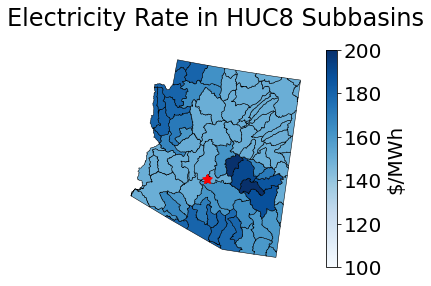

In [129]:
# Arizona
ax = visualize_stats(huc_subbasins[huc_subbasins['in_AZ']], 'elec_rate', 'Electricity Rate in HUC8 Subbasins', 'Blues', '$/MWh', cmap_lims=[100, 200], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/elec_rate_AZ.png", dpi=200, bbox_inches="tight")

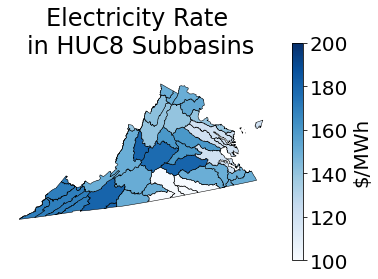

In [130]:
# Virginia
ax = visualize_stats(huc_subbasins[huc_subbasins['in_VA']], 'elec_rate', 'Electricity Rate \nin HUC8 Subbasins', 'Blues', '$/MWh', cmap_lims=[100, 200])

fig = ax.get_figure()

fig.savefig("Figures/elec_rate_VA.png", dpi=200, bbox_inches="tight")

Water stress factor

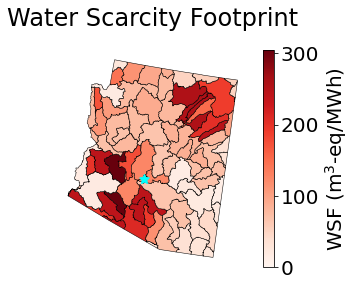

In [107]:
# Arizona
ax = visualize_stats(huc_subbasins[huc_subbasins['in_AZ']], 'WSF_1MW_DC', 'Water Scarcity Footprint', 'Reds', r'WSF (m$^3$-eq/MWh)', cmap_lims=[0, huc_subbasins['WSF_1MW_DC'].max()], interest_point_list=[(33.4482, -112.0777)], point_color='cyan')

fig = ax.get_figure()
# fig.savefig("Figures/wsf_AZ.png", dpi=200, bbox_inches="tight")

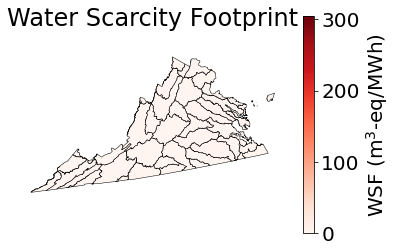

In [108]:
# Virginia
ax = visualize_stats(huc_subbasins[huc_subbasins['in_VA']], 'WSF_1MW_DC', 'Water Scarcity Footprint', 'Reds', r'WSF (m$^3$-eq/MWh)', cmap_lims=[0, huc_subbasins['WSF_1MW_DC'].max()])

fig = ax.get_figure()
# fig.savefig("Figures/wsf_VA.png", dpi=200, bbox_inches="tight")

Emissions

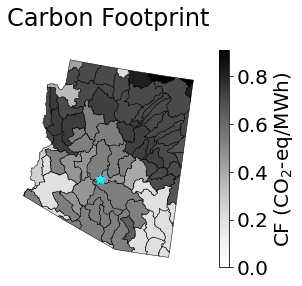

In [ ]:
# Arizona
ax = visualize_stats(huc_subbasins[huc_subbasins['in_AZ']], 'CF_1MW_DC', 'Carbon Footprint', 'Greys', r'CF (kg CO$_{2}$-eq/MWh)', cmap_lims=[0, huc_subbasins['CF_1MW_DC'].max()], interest_point_list=[(33.4482, -112.0777)], point_color='cyan')

fig = ax.get_figure()
fig.savefig("Figures/carbon_AZ.png", dpi=200, bbox_inches="tight")

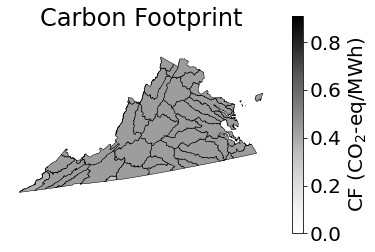

In [ ]:
# Virginia
ax = visualize_stats(huc_subbasins[huc_subbasins['in_VA']], 'CF_1MW_DC', 'Carbon Footprint', 'Greys', r'CF (kg CO$_{2}$-eq/MWh)', cmap_lims=[0, huc_subbasins['CF_1MW_DC'].max()])

fig = ax.get_figure()
fig.savefig("Figures/carbon_VA.png", dpi=200, bbox_inches="tight")

Existing Data Centers

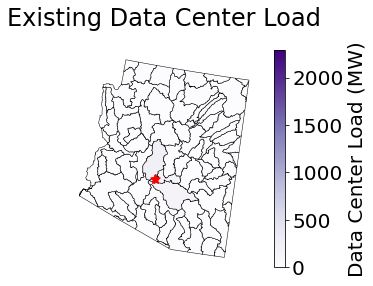

In [87]:
# Arizona
ax = visualize_stats(huc_subbasins[huc_subbasins['in_AZ']], 'existing_MW', 'Existing Data Center Load', 'Purples', r'Data Center Load (MW)', cmap_lims=[0, huc_subbasins['existing_MW'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()
fig.savefig("Figures/existing_load_AZ.png", dpi=200, bbox_inches="tight")

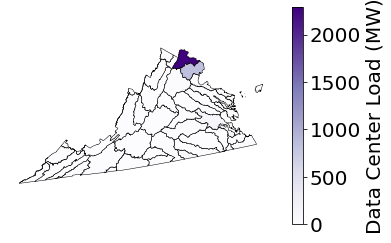

In [147]:
# Virginia
ax = visualize_stats(huc_subbasins[huc_subbasins['in_VA']], 'existing_MW', '', 'Purples', r'Data Center Load (MW)', cmap_lims=[0, huc_subbasins['existing_MW'].max()])

fig = ax.get_figure()
fig.savefig("Figures/existing_load_VA.png", dpi=200, bbox_inches="tight")

In [111]:
print(f"In total, the current amount of data center load in Arizona and Virginia is {np.sum(huc_subbasins['existing_MW']):.0f} MW.")

In total, the current amount of data center load in Arizona and Virginia is 4006 MW.


Existing water stress

In [79]:
huc_subbasins['existing_WSF'] = huc_subbasins['WSF_1MW_DC']*huc_subbasins['existing_MW']*24*365

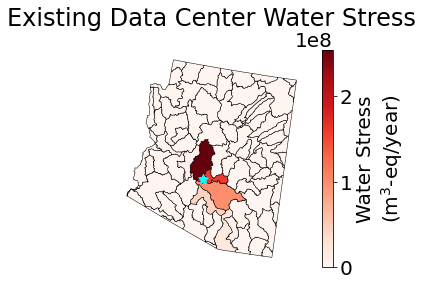

In [81]:
# Arizona
ax = visualize_stats(huc_subbasins[huc_subbasins['in_AZ']], 'existing_WSF', 'Existing Data Center Water Stress', 'Reds', 'Water Stress\n' + r'(m$^3$-eq/year)', cmap_lims=[0, huc_subbasins['existing_WSF'].max()], interest_point_list=[(33.4482, -112.0777)], point_color='cyan')

fig = ax.get_figure()
fig.savefig("Figures/existing_water_stress_AZ.png", dpi=200, bbox_inches="tight")

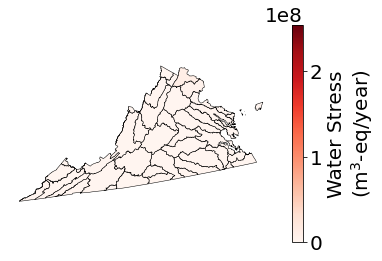

In [157]:
# Virginia
ax = visualize_stats(huc_subbasins[huc_subbasins['in_VA']], 'existing_WSF', '', 'Reds', 'Water Stress\n' + r'(m$^3$-eq/year)', cmap_lims=[0, huc_subbasins['existing_WSF'].max()])

fig = ax.get_figure()
fig.savefig("Figures/existing_water_stress_VA.png", dpi=200, bbox_inches="tight")

Solar capacity factor

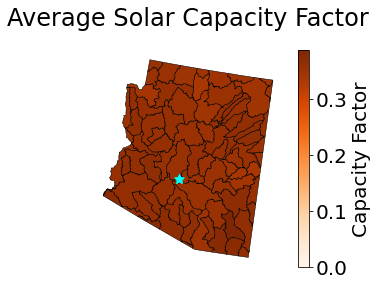

In [88]:
# Arizona
ax = visualize_stats(huc_subbasins[huc_subbasins['in_AZ']], 'Solar_CF', 'Average Solar Capacity Factor', 'Oranges', r'Capacity Factor', cmap_lims=[0, huc_subbasins['Solar_CF'].max()], interest_point_list=[(33.4482, -112.0777)], point_color='cyan')

fig = ax.get_figure()
fig.savefig("Figures/solar_CF_AZ.png", dpi=200, bbox_inches="tight")

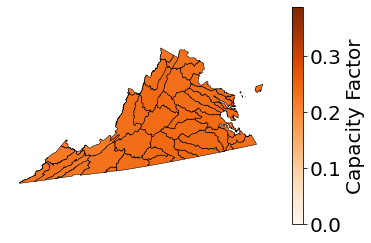

In [89]:
# Virginia
ax = visualize_stats(huc_subbasins[huc_subbasins['in_VA']], 'Solar_CF', '', 'Oranges', r'Capacity Factor', cmap_lims=[0, huc_subbasins['Solar_CF'].max()])

fig = ax.get_figure()
fig.savefig("Figures/solar_CF_VA.png", dpi=200, bbox_inches="tight")

Wind capacity factor

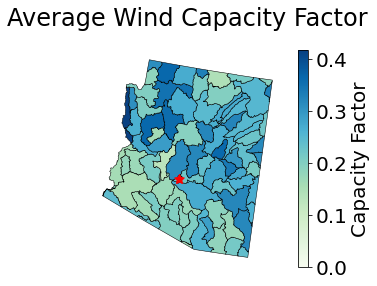

In [91]:
# Arizona
ax = visualize_stats(huc_subbasins[huc_subbasins['in_AZ']], 'Wind_CF', 'Average Wind Capacity Factor', 'GnBu', r'Capacity Factor', cmap_lims=[0, huc_subbasins['Wind_CF'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()
fig.savefig("Figures/wind_CF_AZ.png", dpi=200, bbox_inches="tight")

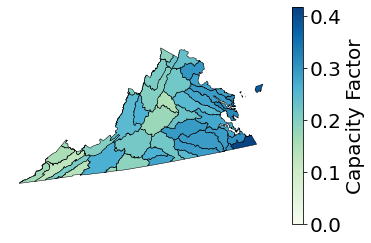

In [93]:
# Virginia
ax = visualize_stats(huc_subbasins[huc_subbasins['in_VA']], 'Wind_CF', '', 'GnBu', r'Capacity Factor', cmap_lims=[0, huc_subbasins['Wind_CF'].max()])

fig = ax.get_figure()
fig.savefig("Figures/wind_CF_VA.png", dpi=200, bbox_inches="tight")

### Implement HUC8 Optimization Model

In [11]:
# import relevant data
solar_subbasin = pd.read_csv("data/data_siting/insolation_AZ_VA_per_watt.csv", index_col=0).values
wind_subbasin = pd.read_csv("data/data_siting/wind_power_per_watt_daily.csv", index_col=0).values

In [14]:
# huc8 list
huc8_iter = huc_subbasins['HUC8_x']

# set index for dataframe
huc_subbasins.set_index(huc8_iter, inplace=True)

# implement optimization model

# normalization, minimum values
# min_vals = {
#     'WSF_1MW_DC': s_min,
#     'tot_price': eplp_min,
#     'CF_1MW_DC': e_min
# }

def opt_add_dc(weights, add_req, existing=True, output=True):
    """ 
    Optimize addition of data centers.

    Parameters
    ----------
        weights: dictionary
            Dictionary of problem weights
        add_req: float  
            Amount of MW of data centers to add
        existing: bool
            If True, include existing in consideration
        output: bool
            If True, print model outputs
    """

# # weights for the objective function
# weights = {
#     'WSF_1MW_DC': 0.1, # because we normalize our values, which I think makes sense, we should inflate this more; there is more variation in WSF than land price, for example, which makes land price more consequential if we did comparable scaling factors. I guess that's a design choice.
#     'tot_price': 0.1,
#     'CF_1MW_DC': 0.1,
#     'basin_max': 0.1,
#     'deficit': 0.6 # the way that we normalize deficit, this will always be a value between 0 and 1. Whereas for the other entries, because we normalize by the minimum, those values are always above 1. So we should make the weight on the deficit higher, in this case we try six times higher.
# }

    model = gp.Model("AddDataCenters")

    # DECISION VARIABLES: 
    x = dict() # amount of datacenter MW to put in each HUC8 subbasin
    s = dict() # amount of solar MW to put in each HUC8 subbasin
    w = dict() # amount of wind MW to put in each HUC8 subbasin
    deficit = dict() # amount of energy deficit per day

    for huc8_code in huc8_iter:
        x[huc8_code] = model.addVar(lb=0, name=f"x_{huc8_code}")
        s[huc8_code] = model.addVar(lb=0, name=f"s_{huc8_code}")
        w[huc8_code] = model.addVar(lb=0, name=f"w_{huc8_code}")

    for day in range(365):
        deficit[day] = model.addVar(lb=0, name=f"deficit_{day}")

    # another decision variable: maximum water stress in any subbasin
    basin_max = model.addVar(lb=0, name="basin_max")

    # OBJECTIVE
    obj = gp.LinExpr()

    # location summation costs
    for huc8_code in huc8_iter:
        for key in ['WSF_1MW_DC_normalize', 'tot_price_normalize', 'CF_1MW_DC_normalize']:
            # obj += x[huc8_code]*(weights[key]*(huc_subbasins.loc[huc8_code, key]/min_vals[key]))
            obj += x[huc8_code]*(weights[key]*(huc_subbasins.loc[huc8_code, key]))

    # maximum water stress cost
    obj += weights['basin_max'] * basin_max/s_min

    # overall deficit cost
    obj += weights['deficit'] * gp.quicksum(deficit[day] for day in range(365))/(24*365)

    model.setObjective(obj, GRB.MINIMIZE)

    # CONSTRAINTS

    # basin_max is at least the water stress in any subbasin
    for huc8_code in huc8_iter:
        if existing:
            model.addConstr(basin_max >= (x[huc8_code] + huc_subbasins.loc[huc8_code, 'existing_M'])*huc_subbasins.loc[huc8_code, 'WSF_1MW_DC'], name=f"basin_max_{huc8_code}")
        else:
            model.addConstr(basin_max >= (x[huc8_code])*huc_subbasins.loc[huc8_code, 'WSF_1MW_DC'], name=f"basin_max_{huc8_code}")


    # add sufficient data center load
    model.addConstr(gp.quicksum(x[huc8_code] for huc8_code in huc8_iter) == add_req, name="add_req")

    # add sufficient solar and wind capacity
    for idx, huc8_code in enumerate(huc8_iter):
        if existing:
            model.addConstr(gp.quicksum(s[huc8_code]*solar_subbasin[day, idx] for day in range(365)) + gp.quicksum(w[huc8_code]*wind_subbasin[day, idx] for day in range(365)) == 365*24*(x[huc8_code] + huc_subbasins.loc[huc8_code, 'existing_M']), name=f"renewables_{huc8_code}")
        else:
            model.addConstr(gp.quicksum(s[huc8_code]*solar_subbasin[day, idx] for day in range(365)) + gp.quicksum(w[huc8_code]*wind_subbasin[day, idx] for day in range(365)) == 365*24*(x[huc8_code]), name=f"renewables_{huc8_code}")

    # penalize the deficit
    for day in range(365):
        if existing:
            model.addConstr(deficit[day] >= (add_req + gp.quicksum(huc_subbasins.loc[huc8_code, 'existing_M'] for huc8_code in huc8_iter))*24 - gp.quicksum((s[huc8_code]*solar_subbasin[day, idx] + w[huc8_code]*wind_subbasin[day, idx]) for idx, huc8_code in enumerate(huc8_iter)), name=f"deficit_constr_{day}")
        else:
            model.addConstr(deficit[day] >= (add_req)*24 - gp.quicksum((s[huc8_code]*solar_subbasin[day, idx] + w[huc8_code]*wind_subbasin[day, idx]) for idx, huc8_code in enumerate(huc8_iter)), name=f"deficit_constr_{day}")

    # optimize!
    model.setParam('OutputFlag', output)
    model.optimize()

    x_list = [x[huc8_code].X for huc8_code in huc8_iter]
    s_list = [s[huc8_code].X for huc8_code in huc8_iter]
    w_list = [w[huc8_code].X for huc8_code in huc8_iter]
    deficit_list = [deficit[d] for d in range(365)]

    return x_list, s_list, w_list, basin_max.X, deficit_list

In [172]:
# our baseline example: 0.2, 0.2, 0.2, 0.2, 0.2

weights_default = {
    'WSF_1MW_DC_normalize': 0.2,
    'tot_price_normalize': 0.2,
    'CF_1MW_DC_normalize': 0.2,
    'basin_max': 0.2,
    'deficit': 0.2
}

x, s, w, basin_max, deficit = opt_add_dc(weights_default, 4000, existing=True)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 630 rows, 762 columns and 96765 nonzeros
Model fingerprint: 0xd87d0873
Coefficient statistics:
  Matrix range     [1e-02, 9e+03]
  Objective range  [2e-05, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+07]
Presolve removed 238 rows and 333 columns
Presolve time: 0.02s
Presolved: 392 rows, 429 columns, 16473 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0078232e+04   3.627765e+06   0.000000e+00      0s
     271    1.5915291e+04   0.000000e+00   0.000000e+00      0s

Solved in 271 iterations and 0.03 seconds (0.07 work units)
Optimal objective  1.591529097e+04


In [16]:
huc_subbasins_weights_default = huc_subbasins.copy()
vitals_list = ['WSF_1MW_DC_normalize', 'tot_price_normalize', 'CF_1MW_DC_normalize']
huc_subbasins_weights_default['combined_vitals'] = np.sum([weights_default[vital]*huc_subbasins_weights_default[vital] for vital in vitals_list], axis=0)
huc_subbasins_weights_default['add_DCs'] = x
huc_subbasins_weights_default['total_DCs'] = huc_subbasins_weights_default['add_DCs'] + huc_subbasins_weights_default['existing_M']

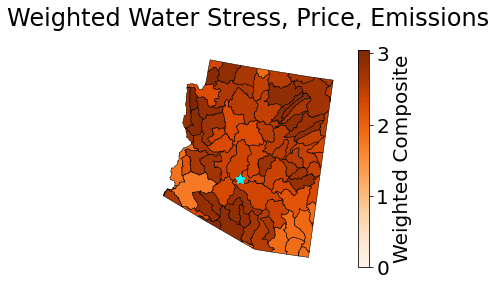

In [22]:
# Arizona
ax = visualize_stats(huc_subbasins_weights_default[huc_subbasins_weights_default['in_AZ']], 'combined_vitals', 'Weighted Water Stress, Price, Emissions', 'Oranges', r'Weighted Composite', cmap_lims=[0, huc_subbasins_weights_default['combined_vitals'].max()], interest_point_list=[(33.4482, -112.0777)], point_color='cyan')

fig = ax.get_figure()

fig.savefig("Figures/weighted_default_composite_AZ.png", dpi=200, bbox_inches='tight')

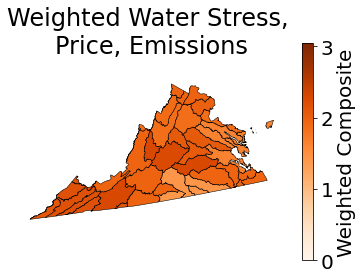

In [23]:
# Virginia
ax = visualize_stats(huc_subbasins_weights_default[huc_subbasins_weights_default['in_VA']], 'combined_vitals', 'Weighted Water Stress, \nPrice, Emissions', 'Oranges', r'Weighted Composite', cmap_lims=[0, huc_subbasins_weights_default['combined_vitals'].max()])

fig = ax.get_figure()

fig.savefig("Figures/weighted_default_composite_VA.png", dpi=200, bbox_inches='tight')

View buildout

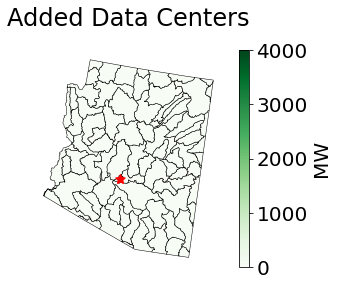

In [24]:
# Arizona
ax = visualize_stats(huc_subbasins_weights_default[huc_subbasins_weights_default['in_AZ']], 'add_DCs', 'Added Data Centers', 'Greens', r'MW', cmap_lims=[0, huc_subbasins_weights_default['add_DCs'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/weights_default_added_DCs_AZ.png", dpi=200, bbox_inches='tight')

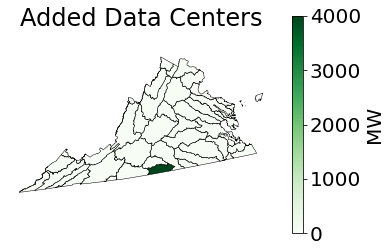

In [25]:
# Virginia
ax = visualize_stats(huc_subbasins_weights_default[huc_subbasins_weights_default['in_VA']], 'add_DCs', 'Added Data Centers', 'Greens', r'MW', cmap_lims=[0, huc_subbasins_weights_default['add_DCs'].max()])

fig = ax.get_figure()

fig.savefig("Figures/weighted_default_added_DCs_VA.png", dpi=200, bbox_inches='tight')

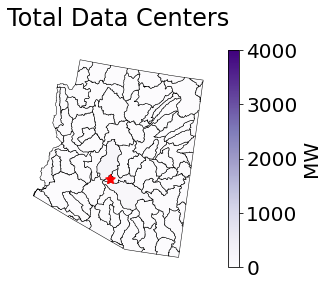

In [26]:
# view total
# Arizona
ax = visualize_stats(huc_subbasins_weights_default[huc_subbasins_weights_default['in_AZ']], 'total_DCs', 'Total Data Centers', 'Purples', 'MW', cmap_lims=[0, huc_subbasins_weights_default['total_DCs'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/weights_default_total_DCs_AZ.png", dpi=200, bbox_inches="tight")

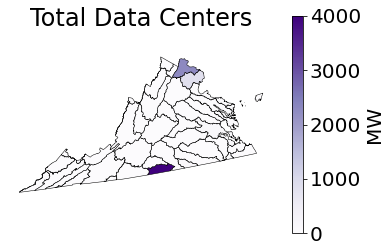

In [27]:
# Virginia
ax = visualize_stats(huc_subbasins_weights_default[huc_subbasins_weights_default['in_VA']], 'total_DCs', 'Total Data Centers', 'Purples', 'MW', cmap_lims=[0, huc_subbasins_weights_default['total_DCs'].max()])

fig = ax.get_figure()

fig.savefig("Figures/weights_default_total_DCs_VA.png", dpi=200, bbox_inches="tight")

Emphasize carbon emissions

In [275]:
weights_CF = {
    'WSF_1MW_DC_normalize': 0.1,
    'tot_price_normalize': 0.1,
    'CF_1MW_DC_normalize': 0.4,
    'basin_max': 0.2,
    'deficit': 0.2
}

x, s, w, basin_max, deficit = opt_add_dc(weights_CF, 4000, existing=True)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 630 rows, 762 columns and 96765 nonzeros
Model fingerprint: 0x188fffa4
Coefficient statistics:
  Matrix range     [1e-02, 9e+03]
  Objective range  [2e-05, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+07]
Presolve removed 223 rows and 293 columns
Presolve time: 0.02s
Presolved: 407 rows, 469 columns, 31068 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0078232e+04   2.422841e+06   0.000000e+00      0s
     275    1.5182747e+04   0.000000e+00   0.000000e+00      0s

Solved in 275 iterations and 0.03 seconds (0.07 work units)
Optimal objective  1.518274746e+04


In [273]:
huc_subbasins_weights_CF = huc_subbasins.copy()
vitals_list = ['WSF_1MW_DC_normalize', 'tot_price_normalize', 'CF_1MW_DC_normalize']
huc_subbasins_weights_CF['combined_vitals'] = np.sum([weights_CF[vital]*huc_subbasins_weights_CF[vital] for vital in vitals_list], axis=0)
huc_subbasins_weights_CF['add_DCs'] = x
huc_subbasins_weights_CF['total_DCs'] = huc_subbasins_weights_CF['add_DCs'] + huc_subbasins_weights_CF['existing_M']

In [278]:
np.array(x)[np.array(x) != 0]

array([ 425.23145036,   92.64470985, 1450.76791499,  687.49604277,
       1343.85988202])

Composite Score

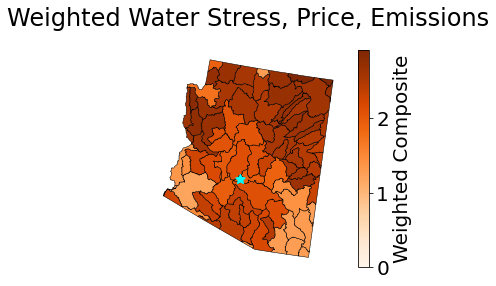

In [64]:
# Arizona
ax = visualize_stats(huc_subbasins_weights_CF[huc_subbasins_weights_CF['in_AZ']], 'combined_vitals', 'Weighted Water Stress, Price, Emissions', 'Oranges', r'Weighted Composite', cmap_lims=[0, huc_subbasins_weights_CF['combined_vitals'].max()], interest_point_list=[(33.4482, -112.0777)], point_color='cyan')

fig = ax.get_figure()

fig.savefig("Figures/weighted_CF_composite_AZ.png", dpi=200, bbox_inches='tight')

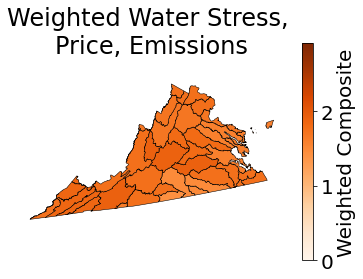

In [65]:
# Virginia
ax = visualize_stats(huc_subbasins_weights_CF[huc_subbasins_weights_CF['in_VA']], 'combined_vitals', 'Weighted Water Stress, \nPrice, Emissions', 'Oranges', r'Weighted Composite', cmap_lims=[0, huc_subbasins_weights_CF['combined_vitals'].max()])

fig = ax.get_figure()

fig.savefig("Figures/weighted_CF_composite_VA.png", dpi=200, bbox_inches='tight')

Added Data Centers

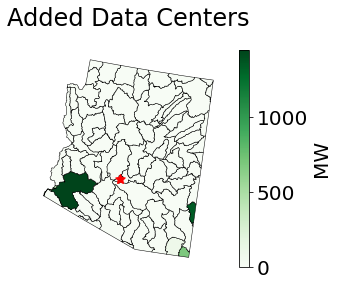

In [286]:
# Arizona
ax = visualize_stats(huc_subbasins_weights_CF[huc_subbasins_weights_CF['in_AZ']], 'add_DCs', 'Added Data Centers', 'Greens', r'MW', cmap_lims=[0, huc_subbasins_weights_CF['add_DCs'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/weights_CF_added_DCs_AZ.png", dpi=200, bbox_inches='tight')

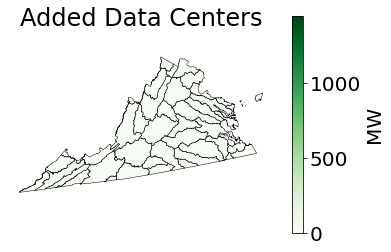

In [280]:
# Virginia
ax = visualize_stats(huc_subbasins_weights_CF[huc_subbasins_weights_CF['in_VA']], 'add_DCs', 'Added Data Centers', 'Greens', r'MW', cmap_lims=[0, huc_subbasins_weights_CF['add_DCs'].max()])

fig = ax.get_figure()

# fig.savefig("Figures/weighted_CF_added_DCs_VA.png", dpi=200, bbox_inches='tight')

Total Data Centers

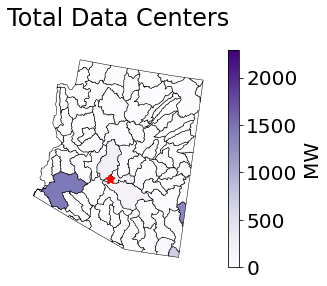

In [56]:
# Arizona
ax = visualize_stats(huc_subbasins_weights_CF[huc_subbasins_weights_CF['in_AZ']], 'total_DCs', 'Total Data Centers', 'Purples', r'MW', cmap_lims=[0, huc_subbasins_weights_CF['total_DCs'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/weights_CF_total_DCs_AZ.png", dpi=200, bbox_inches='tight')

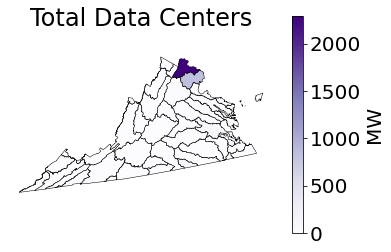

In [57]:
# Virginia
ax = visualize_stats(huc_subbasins_weights_CF[huc_subbasins_weights_CF['in_VA']], 'total_DCs', 'Total Data Centers', 'Purples', 'MW', cmap_lims=[0, huc_subbasins_weights_CF['total_DCs'].max()])

fig = ax.get_figure()

fig.savefig("Figures/weights_CF_total_DCs_VA.png", dpi=200, bbox_inches="tight")

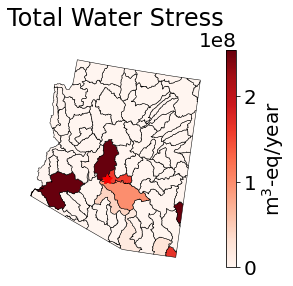

In [287]:
# Arizona
huc_subbasins_weights_CF['total_WSF'] = huc_subbasins_weights_CF['WSF_1MW_DC'] * huc_subbasins_weights_CF['total_DCs'] * 8760

ax = visualize_stats(huc_subbasins_weights_CF[huc_subbasins_weights_CF['in_AZ']], 'total_WSF', 'Total Water Stress', 'Reds', r'm$^3$-eq/year', cmap_lims=[0, huc_subbasins_weights_CF['total_WSF'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/weights_CF_total_WSF_AZ.png", dpi=200, bbox_inches='tight')

# print(np.sort((huc_subbasins_weights_CF['WSF_1MW_DC'] * huc_subbasins_weights_CF['total_DCs']).values))

In [289]:
huc_subbasins_weights_CF.sort_values(by=['total_WSF'])

,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,...,existing_W,geometry,WSF_1MW_DC_normalize,tot_price_normalize,CF_1MW_DC_normalize,existing_WSF,combined_vitals,add_DCs,total_DCs,total_WSF
HUC8_x,,,,,,,,,,,,,,,,,,,,,
15080200,{A078F6A3-1492-4880-AB0B-556324E832FA},None,None,None,None,2012/06/11,0,6358140.45,25730.50,"AZ,MX",...,0.000000e+00,"POLYGON ((-1433526.21 1046769.093, -1433504.15...",-0.522744,9.747073,1.135684,0.000000e+00,1.376706,0.000000,0.000000,0.000000e+00
06010101,{0FE1A1E3-A280-496F-865B-060616C61E45},None,None,None,None,2017/04/03,0,465106.72,1882.22,"TN,VA",...,0.000000e+00,"POLYGON ((1279210.945 1658667.651, 1279203.128...",-0.840421,9.205673,2.546104,0.000000e+00,1.854967,0.000000,0.000000,0.000000e+00
03010103,{EBF5A315-2A93-48E9-9552-62EF2CBBA767},None,None,None,None,2012/06/11,0,1315517.15,5323.71,"NC,VA",...,0.000000e+00,"POLYGON ((1443690.598 1656692.495, 1443672.273...",-0.840426,8.180144,2.546104,0.000000e+00,1.752413,0.000000,0.000000,0.000000e+00
14080105,{9CE10C90-4927-4081-A2DE-D75ACBD9AB0E},None,None,None,None,2012/06/11,0,1244784.87,5037.47,"AZ,CO,NM",...,0.000000e+00,"POLYGON ((-1154874.284 1568923.325, -1154877.2...",-0.240886,8.122597,4.749336,0.000000e+00,2.687906,0.000000,0.000000,0.000000e+00
06010102,{A361D297-B2F7-4889-B76F-21FD6509F762},None,None,None,None,2017/04/03,0,754769.60,3054.45,"NC,TN,VA",...,0.000000e+00,"MULTIPOLYGON (((1190885.509 1590056.222, 11909...",-0.844452,9.206073,2.546104,0.000000e+00,1.854604,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15080302,{CC61820E-2F90-4E9B-AE46-4C877CBC53FB},None,None,None,None,2012/06/11,0,885080.83,3581.80,"AZ,MX,NM",...,0.000000e+00,"POLYGON ((-1251213.795 1039683.932, -1251117.2...",-0.518955,8.664040,1.135684,0.000000e+00,1.268782,687.496043,687.496043,1.674131e+08
15030107,{B76D3BD6-0284-4214-B645-E164287FF0D9},None,None,None,None,2012/06/11,0,986669.08,3992.91,"AZ,CA,MX",...,0.000000e+00,"POLYGON ((-1706595.504 1256564.425, -1706557.3...",-0.032523,8.124630,1.014958,0.000000e+00,1.215194,425.231450,425.231450,2.540954e+08
15070201,{560D9857-464D-4283-9447-81C9274D2856},None,None,None,None,2018/03/02,0,2683099.79,10858.13,AZ,...,0.000000e+00,"POLYGON ((-1598084.18 1303518.229, -1598072.22...",-0.612888,8.122515,1.135684,0.000000e+00,1.205236,1450.767915,1450.767915,2.540954e+08


Emphasize renewables

In [268]:
weights_renewables = {
    'WSF_1MW_DC_normalize': 0.05,
    'tot_price_normalize': 0.05,
    'CF_1MW_DC_normalize': 0.05,
    'basin_max': 0.05,
    'deficit': 0.8
}

x, s, w, basin_max, deficit = opt_add_dc(weights_renewables, 4000, existing=True)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 630 rows, 762 columns and 96765 nonzeros
Model fingerprint: 0x55fa3bfa
Coefficient statistics:
  Matrix range     [1e-02, 9e+03]
  Objective range  [9e-05, 8e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+07]
Presolve removed 161 rows and 113 columns
Presolve time: 0.02s
Presolved: 469 rows, 649 columns, 96520 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.054e+05
 Factor NZ  : 1.067e+05 (roughly 1 MB of memory)
 Factor Ops : 3.226e+07 (less than 1 second per iteration)
 Threads    : 8

Barrier performed 0 iterations in 0.05 seconds (0.05 work units)
Barrier solve interrupted - model solved by another algo

In [270]:
np.sum([np.array(x) != 0])

np.int64(5)

In [271]:
huc_subbasins_weights_renewables = huc_subbasins.copy()
vitals_list = ['WSF_1MW_DC_normalize', 'tot_price_normalize', 'CF_1MW_DC_normalize']
huc_subbasins_weights_renewables['combined_vitals'] = np.sum([weights_renewables[vital]*huc_subbasins_weights_renewables[vital] for vital in vitals_list], axis=0)
huc_subbasins_weights_renewables['add_DCs'] = x
huc_subbasins_weights_renewables['total_DCs'] = huc_subbasins_weights_renewables['add_DCs'] + huc_subbasins_weights_renewables['existing_M']
huc_subbasins_weights_renewables['add_solar'] = s
huc_subbasins_weights_renewables['add_wind'] = w

Composite Score

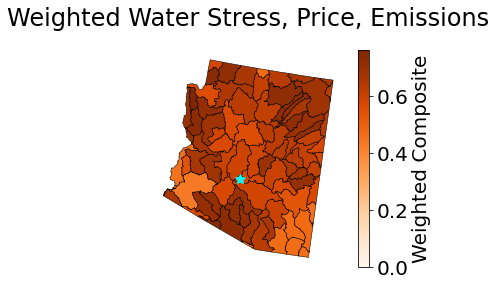

In [83]:
# Arizona
ax = visualize_stats(huc_subbasins_weights_renewables[huc_subbasins_weights_renewables['in_AZ']], 'combined_vitals', 'Weighted Water Stress, Price, Emissions', 'Oranges', r'Weighted Composite', cmap_lims=[0, huc_subbasins_weights_renewables['combined_vitals'].max()], interest_point_list=[(33.4482, -112.0777)], point_color='cyan')

fig = ax.get_figure()

fig.savefig("Figures/weighted_renewables_composite_AZ.png", dpi=200, bbox_inches='tight')

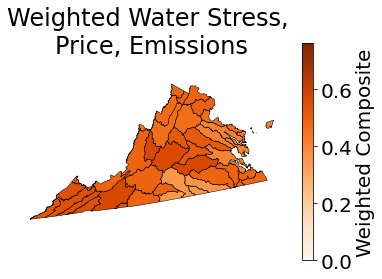

In [84]:
# Virginia
ax = visualize_stats(huc_subbasins_weights_renewables[huc_subbasins_weights_renewables['in_VA']], 'combined_vitals', 'Weighted Water Stress, \nPrice, Emissions', 'Oranges', r'Weighted Composite', cmap_lims=[0, huc_subbasins_weights_renewables['combined_vitals'].max()])

fig = ax.get_figure()

fig.savefig("Figures/weighted_renewables_composite_VA.png", dpi=200, bbox_inches='tight')

Added Data Centers

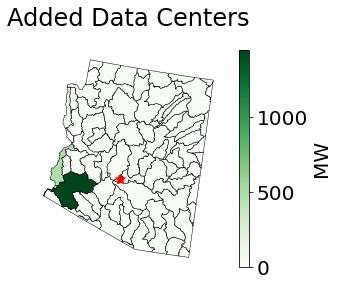

In [85]:
# Arizona
ax = visualize_stats(huc_subbasins_weights_renewables[huc_subbasins_weights_renewables['in_AZ']], 'add_DCs', 'Added Data Centers', 'Greens', r'MW', cmap_lims=[0, huc_subbasins_weights_renewables['add_DCs'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/weights_renewables_added_DCs_AZ.png", dpi=200, bbox_inches='tight')

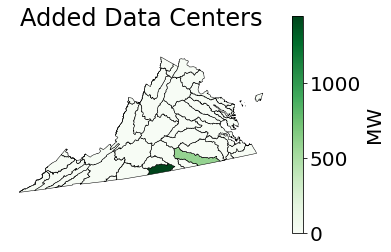

In [ ]:
# Virginia
ax = visualize_stats(huc_subbasins_weights_renewables[huc_subbasins_weights_renewables['in_VA']], 'add_DCs', 'Added Data Centers', 'Greens', r'MW', cmap_lims=[0, huc_subbasins_weights_renewables['add_DCs'].max()])

fig = ax.get_figure()

fig.savefig("Figures/weighted_renewables_added_DCs_VA.png", dpi=200, bbox_inches='tight')

Total Data Centers

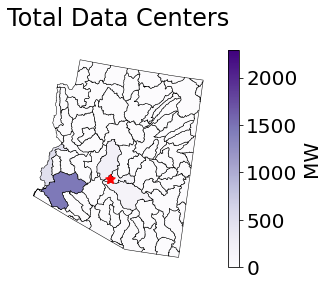

In [89]:
# Arizona
ax = visualize_stats(huc_subbasins_weights_renewables[huc_subbasins_weights_renewables['in_AZ']], 'total_DCs', 'Total Data Centers', 'Purples', r'MW', cmap_lims=[0, huc_subbasins_weights_renewables['total_DCs'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/weights_renewables_total_DCs_AZ.png", dpi=200, bbox_inches='tight')

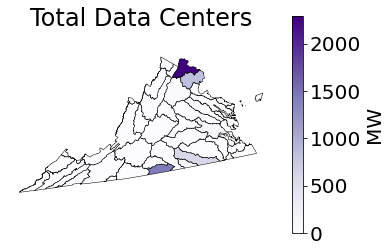

In [90]:
# Virginia
ax = visualize_stats(huc_subbasins_weights_renewables[huc_subbasins_weights_renewables['in_VA']], 'total_DCs', 'Total Data Centers', 'Purples', 'MW', cmap_lims=[0, huc_subbasins_weights_renewables['total_DCs'].max()])

fig = ax.get_figure()

fig.savefig("Figures/weights_renewables_total_DCs_VA.png", dpi=200, bbox_inches="tight")

Renewables

Solar

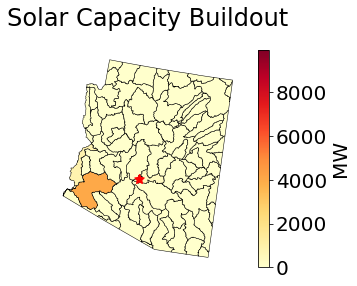

In [100]:
# arizona
ax = visualize_stats(huc_subbasins_weights_renewables[huc_subbasins_weights_renewables['in_AZ']], 'add_solar', 'Solar Capacity Buildout', 'YlOrRd', r'MW', cmap_lims=[0, huc_subbasins_weights_renewables['add_solar'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/weights_renewables_add_solar_AZ.png", dpi=200, bbox_inches='tight')

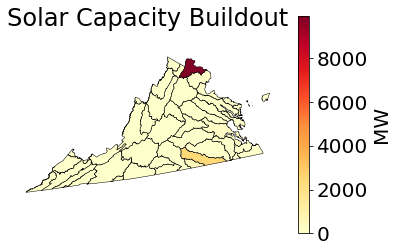

In [101]:
# virginia
ax = visualize_stats(huc_subbasins_weights_renewables[huc_subbasins_weights_renewables['in_VA']], 'add_solar', 'Solar Capacity Buildout', 'YlOrRd', r'MW', cmap_lims=[0, huc_subbasins_weights_renewables['add_solar'].max()])

fig = ax.get_figure()

fig.savefig("Figures/weights_renewables_add_solar_VA.png", dpi=200, bbox_inches='tight')

Wind

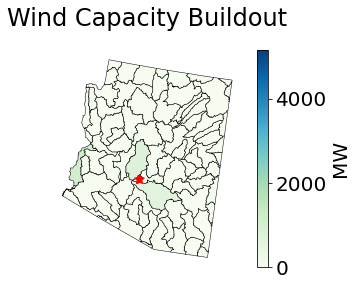

In [105]:
# arizona
ax = visualize_stats(huc_subbasins_weights_renewables[huc_subbasins_weights_renewables['in_AZ']], 'add_wind', 'Wind Capacity Buildout', 'GnBu', r'MW', cmap_lims=[0, huc_subbasins_weights_renewables['add_wind'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/weights_renewables_add_wind_AZ.png", dpi=200, bbox_inches='tight')

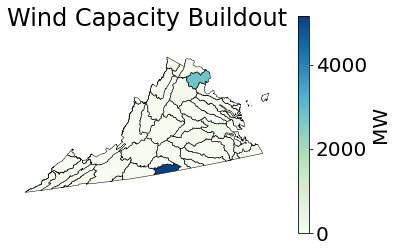

In [106]:
# virginia
ax = visualize_stats(huc_subbasins_weights_renewables[huc_subbasins_weights_renewables['in_VA']], 'add_wind', 'Wind Capacity Buildout', 'GnBu', r'MW', cmap_lims=[0, huc_subbasins_weights_renewables['add_wind'].max()])

fig = ax.get_figure()

fig.savefig("Figures/weights_renewables_add_wind_VA.png", dpi=200, bbox_inches='tight')

Complementarity: wind and solar

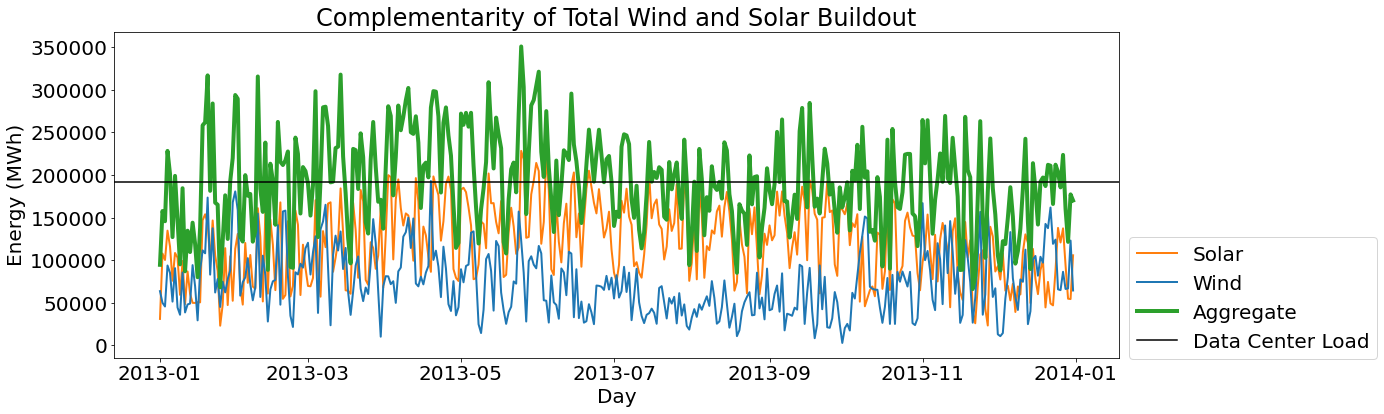

In [201]:
# check complementarity

# look at complementarity: wind and solar
fig, ax = plt.subplots(figsize=(18, 6))

solar_series = np.sum([(s[idx] * solar_gen[:, idx]) for idx in range(len(huc8_iter))], axis=0) 
wind_series = np.sum([(w[idx] * wind_gen[:, idx]) for idx in range(len(huc8_iter))], axis=0)

ax.plot(pd.date_range('2013-01-01', '2013-12-31'), solar_series, color="C1", linewidth=2, label="Solar")
ax.plot(pd.date_range('2013-01-01', '2013-12-31'), wind_series, color="C0", linewidth=2, label="Wind")

# plot the total now
ax.plot(pd.date_range('2013-01-01', '2013-12-31'), solar_series+wind_series, color="C2", linewidth=4, label="Aggregate")

ax.axhline((4000+np.sum(huc_subbasins['existing_M']))*24, color="black", label="Data Center Load")

ax.set_xlabel("Day")
ax.set_ylabel("Energy (MWh)")

ax.legend(bbox_to_anchor=(1,0.4))

ax.set_title("Complementarity of Total Wind and Solar Buildout")

fig.savefig("Figures/weights_renewables_solar_wind_complementarity.png", dpi=200, bbox_inches='tight')

In [203]:
slope, intercept, rvalue, pvalue, _ = stats.linregress(solar_series, wind_series)

print(f"The estimated slope of solar versus wind data is {slope:.3f}, and the p-value from testing whether the slope is 0 is {pvalue:.3f}.")

The estimated slope of solar versus wind data is -0.092, and the p-value from testing whether the slope is 0 is 0.037.


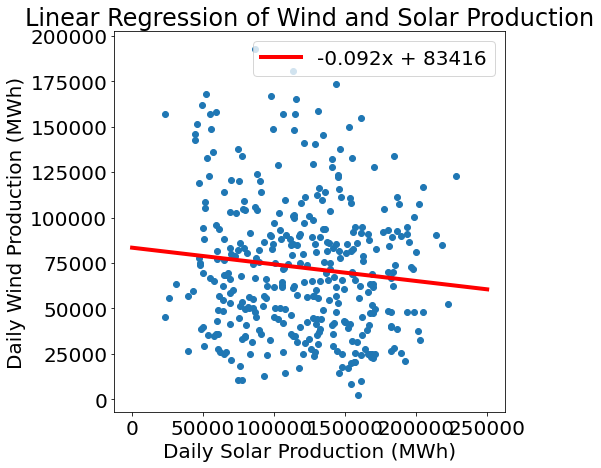

In [204]:
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(solar_series, wind_series)
ax.plot(np.linspace(0,250000), slope*np.linspace(0,250000)+intercept, color="red", linewidth=4, label=rf"{slope:.3f}x + {intercept:.0f}")

ax.set_xlabel("Daily Solar Production (MWh)")
ax.set_ylabel("Daily Wind Production (MWh)")

ax.legend()

ax.set_title("Linear Regression of Wind and Solar Production")

fig.savefig("Figures/weights_renewables_solar_wind_scatter.png", dpi=200, bbox_inches="tight")

Complementarity: Arizona and Virginia

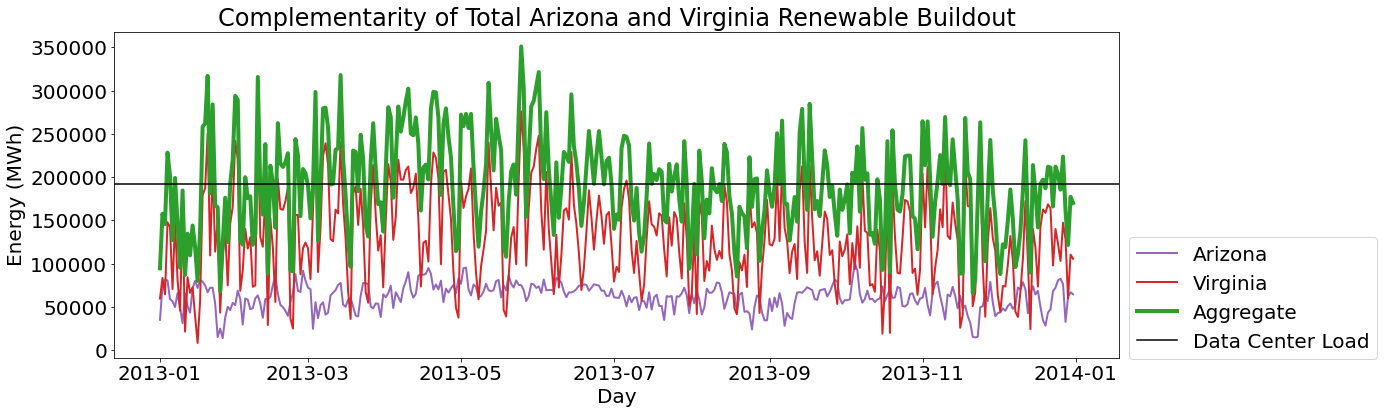

In [205]:
# check complementarity

# look at complementarity: Arizona and Virginia
fig, ax = plt.subplots(figsize=(18, 6))

arizona_series = np.sum([(s[idx] * solar_gen[:, idx] + w[idx] * wind_gen[:, idx]) for idx in range(len(huc8_iter)) if huc_subbasins['in_AZ'].iloc[idx]], axis=0) 
virginia_series = np.sum([(s[idx] * solar_gen[:, idx] + w[idx] * wind_gen[:, idx]) for idx in range(len(huc8_iter)) if huc_subbasins['in_VA'].iloc[idx]], axis=0)

ax.plot(pd.date_range('2013-01-01', '2013-12-31'), arizona_series, color="C4", linewidth=2, label="Arizona")
ax.plot(pd.date_range('2013-01-01', '2013-12-31'), virginia_series, color="C3", linewidth=2, label="Virginia")

# # plot the total now
ax.plot(pd.date_range('2013-01-01', '2013-12-31'), arizona_series+virginia_series, color="C2", linewidth=4, label="Aggregate")

ax.axhline((4000+np.sum(huc_subbasins['existing_M']))*24, color="black", label="Data Center Load")

ax.set_xlabel("Day")
ax.set_ylabel("Energy (MWh)")

ax.legend(bbox_to_anchor=(1,0.4))

ax.set_title("Complementarity of Total Arizona and Virginia Renewable Buildout")

fig.savefig("Figures/weights_renewables_AZ_VA_complementarity.png", dpi=200, bbox_inches='tight')

In [206]:
slope, intercept, rvalue, pvalue, _ = stats.linregress(arizona_series, virginia_series)

print(f"The estimated slope of Arizona versus Virginia data is {slope:.3f}, and the p-value from testing whether the slope is 0 is {pvalue:.3f}.")

The estimated slope of Arizona versus Virginia data is 0.022, and the p-value from testing whether the slope is 0 is 0.907.


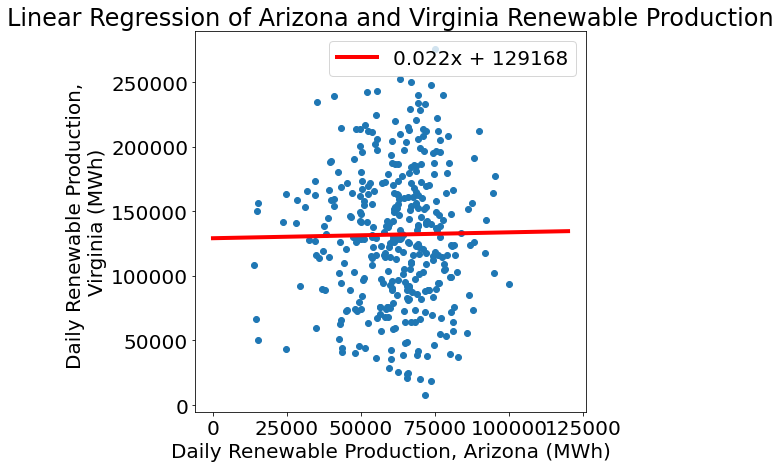

In [207]:
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(arizona_series, virginia_series)
ax.plot(np.linspace(0,120000), slope*np.linspace(0,250000)+intercept, color="red", linewidth=4, label=rf"{slope:.3f}x + {intercept:.0f}")

ax.set_xlabel("Daily Renewable Production, Arizona (MWh)")
ax.set_ylabel("Daily Renewable Production, \nVirginia (MWh)")

ax.legend()

ax.set_title("Linear Regression of Arizona and Virginia Renewable Production")

fig.savefig("Figures/weights_renewables_AZ_VA_scatter.png", dpi=200, bbox_inches="tight")

### Ignore Existing Data Centers

In [208]:
# now ignoring existing ones
weights_ignore = {
    'WSF_1MW_DC_normalize': 0.2,
    'tot_price_normalize': 0.2,
    'CF_1MW_DC_normalize': 0.2,
    'basin_max': 0.2,
    'deficit': 0.2
}

x, s, w, basin_max, deficit = opt_add_dc(weights_ignore, 4000, existing=False)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 630 rows, 762 columns and 96765 nonzeros
Model fingerprint: 0x89494dbd
Coefficient statistics:
  Matrix range     [1e-02, 9e+03]
  Objective range  [2e-05, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+03, 1e+05]
Presolve removed 251 rows and 370 columns
Presolve time: 0.02s
Presolved: 379 rows, 392 columns, 9892 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5930676e+03   3.312376e+05   0.000000e+00      0s
     194    6.0756438e+03   0.000000e+00   0.000000e+00      0s

Solved in 194 iterations and 0.03 seconds (0.06 work units)
Optimal objective  6.075643763e+03


In [182]:
huc_subbasins_ignore = huc_subbasins.copy()
huc_subbasins_ignore['combined_vitals'] = np.sum([weights_ignore[vital]*huc_subbasins_ignore[vital] for vital in vitals_list], axis=0)
huc_subbasins_ignore['add_DCs'] = x
huc_subbasins_ignore['total_DCs'] = huc_subbasins_ignore['add_DCs'] + huc_subbasins_ignore['existing_M']
huc_subbasins_ignore['add_solar'] = s
huc_subbasins_ignore['add_wind'] = w

Added Data Centers

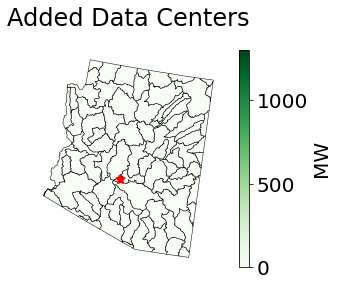

In [184]:
# Arizona
ax = visualize_stats(huc_subbasins_ignore[huc_subbasins_ignore['in_AZ']], 'add_DCs', 'Added Data Centers', 'Greens', r'MW', cmap_lims=[0, huc_subbasins_ignore['add_DCs'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/ignore_added_DCs_AZ.png", dpi=200, bbox_inches='tight')

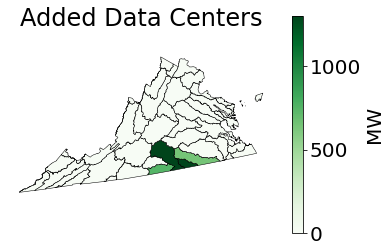

In [186]:
# Virginia
ax = visualize_stats(huc_subbasins_ignore[huc_subbasins_ignore['in_VA']], 'add_DCs', 'Added Data Centers', 'Greens', r'MW', cmap_lims=[0, huc_subbasins_ignore['add_DCs'].max()])

fig = ax.get_figure()

fig.savefig("Figures/ignore_added_DCs_VA.png", dpi=200, bbox_inches='tight')

Total Data Centers

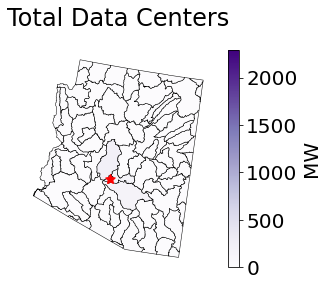

In [188]:
# Arizona
ax = visualize_stats(huc_subbasins_ignore[huc_subbasins_ignore['in_AZ']], 'total_DCs', 'Total Data Centers', 'Purples', r'MW', cmap_lims=[0, huc_subbasins_ignore['total_DCs'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/ignore_total_DCs_AZ.png", dpi=200, bbox_inches='tight')

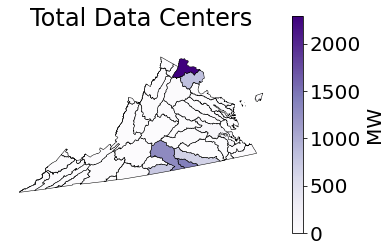

In [192]:
# Virginia
ax = visualize_stats(huc_subbasins_ignore[huc_subbasins_ignore['in_VA']], 'total_DCs', 'Total Data Centers', 'Purples', 'MW', cmap_lims=[0, huc_subbasins_ignore['total_DCs'].max()])

fig = ax.get_figure()

fig.savefig("Figures/ignore_total_DCs_VA.png", dpi=200, bbox_inches="tight")

Solar generation

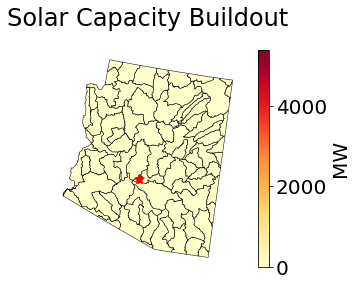

In [193]:
# arizona
ax = visualize_stats(huc_subbasins_ignore[huc_subbasins_ignore['in_AZ']], 'add_solar', 'Solar Capacity Buildout', 'YlOrRd', r'MW', cmap_lims=[0, huc_subbasins_ignore['add_solar'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/ignore_add_solar_AZ.png", dpi=200, bbox_inches='tight')

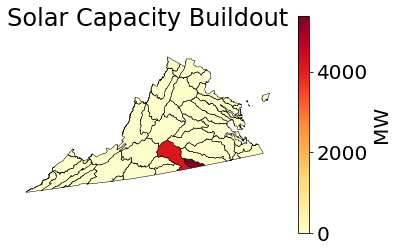

In [195]:
# virginia
ax = visualize_stats(huc_subbasins_ignore[huc_subbasins_ignore['in_VA']], 'add_solar', 'Solar Capacity Buildout', 'YlOrRd', r'MW', cmap_lims=[0, huc_subbasins_ignore['add_solar'].max()])

fig = ax.get_figure()

fig.savefig("Figures/ignore_add_solar_VA.png", dpi=200, bbox_inches='tight')

Wind

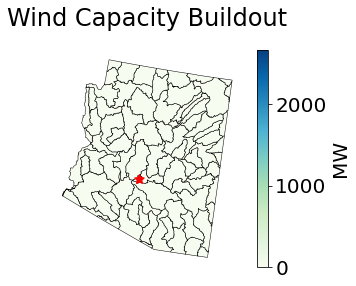

In [197]:
# arizona
ax = visualize_stats(huc_subbasins_ignore[huc_subbasins_ignore['in_AZ']], 'add_wind', 'Wind Capacity Buildout', 'GnBu', r'MW', cmap_lims=[0, huc_subbasins_ignore['add_wind'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

fig.savefig("Figures/ignore_add_wind_AZ.png", dpi=200, bbox_inches='tight')

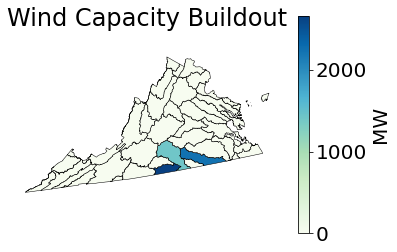

In [198]:
# virginia
ax = visualize_stats(huc_subbasins_ignore[huc_subbasins_ignore['in_VA']], 'add_wind', 'Wind Capacity Buildout', 'GnBu', r'MW', cmap_lims=[0, huc_subbasins_ignore['add_wind'].max()])

fig = ax.get_figure()

fig.savefig("Figures/ignore_add_wind_VA.png", dpi=200, bbox_inches='tight')

Complementarity

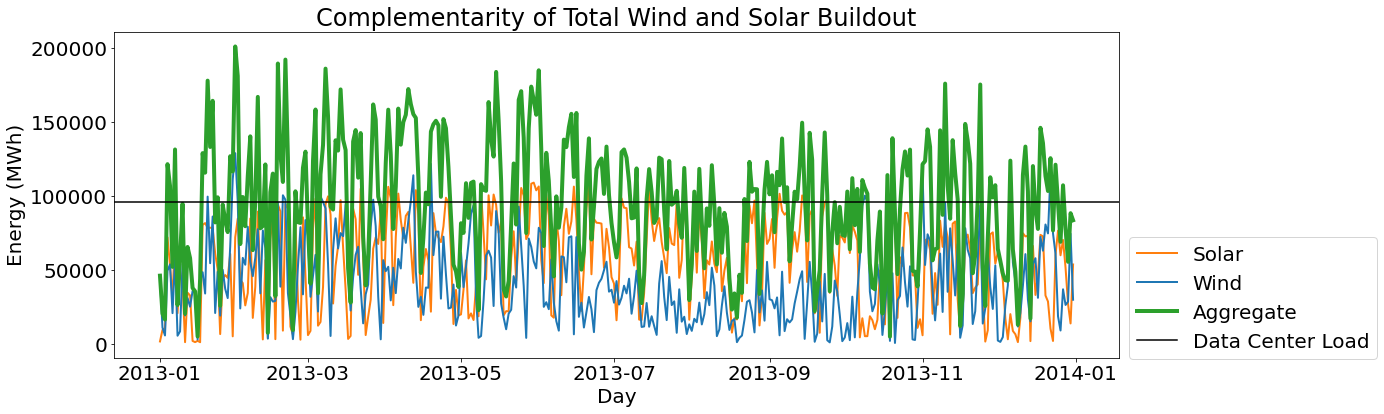

In [211]:
# check complementarity

# look at complementarity: wind and solar
fig, ax = plt.subplots(figsize=(18, 6))

solar_series = np.sum([(s[idx] * solar_gen[:, idx]) for idx in range(len(huc8_iter))], axis=0) 
wind_series = np.sum([(w[idx] * wind_gen[:, idx]) for idx in range(len(huc8_iter))], axis=0)

ax.plot(pd.date_range('2013-01-01', '2013-12-31'), solar_series, color="C1", linewidth=2, label="Solar")
ax.plot(pd.date_range('2013-01-01', '2013-12-31'), wind_series, color="C0", linewidth=2, label="Wind")

# plot the total now
ax.plot(pd.date_range('2013-01-01', '2013-12-31'), solar_series+wind_series, color="C2", linewidth=4, label="Aggregate")

ax.axhline((4000)*24, color="black", label="Data Center Load")

ax.set_xlabel("Day")
ax.set_ylabel("Energy (MWh)")

ax.legend(bbox_to_anchor=(1,0.4))

ax.set_title("Complementarity of Total Wind and Solar Buildout")

fig.savefig("Figures/ignore_solar_wind_complementarity.png", dpi=200, bbox_inches='tight')

In [213]:
slope, intercept, rvalue, pvalue, _ = stats.linregress(solar_series, wind_series)

print(f"The estimated slope of solar versus wind data is {slope:.3f}, and the p-value from testing whether the slope is 0 is {pvalue:.3f}.")

The estimated slope of solar versus wind data is 0.011, and the p-value from testing whether the slope is 0 is 0.815.


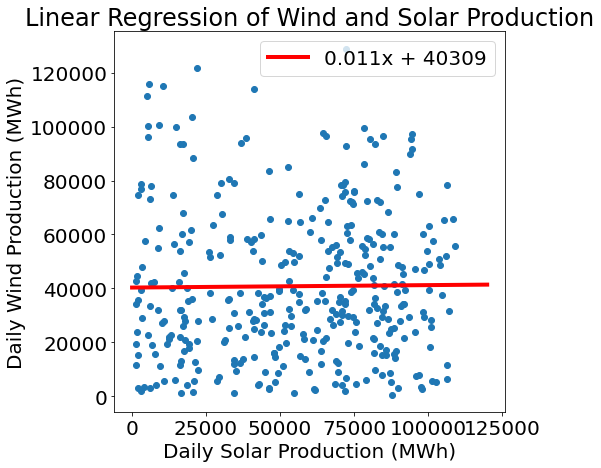

In [217]:
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(solar_series, wind_series)
ax.plot(np.linspace(0,120000), slope*np.linspace(0,100000)+intercept, color="red", linewidth=4, label=rf"{slope:.3f}x + {intercept:.0f}")

ax.set_xlabel("Daily Solar Production (MWh)")
ax.set_ylabel("Daily Wind Production (MWh)")

ax.legend()

ax.set_title("Linear Regression of Wind and Solar Production")

fig.savefig("Figures/ignore_solar_wind_scatter.png", dpi=200, bbox_inches="tight")

In [224]:
# now ignoring existing ones
weights_renewables_ignore = {
    'WSF_1MW_DC_normalize': 0.05,
    'tot_price_normalize': 0.05,
    'CF_1MW_DC_normalize': 0.05,
    'basin_max': 0.05,
    'deficit': 0.8
}

x, s, w, basin_max, deficit = opt_add_dc(weights_renewables_ignore, 4000, existing=False)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 630 rows, 762 columns and 96765 nonzeros
Model fingerprint: 0x244aa0fe
Coefficient statistics:
  Matrix range     [1e-02, 9e+03]
  Objective range  [9e-05, 8e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+03, 1e+05]
Presolve removed 132 rows and 132 columns
Presolve time: 0.02s
Presolved: 498 rows, 630 columns, 96633 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.238e+05
 Factor NZ  : 1.243e+05 (roughly 1 MB of memory)
 Factor Ops : 4.129e+07 (less than 1 second per iteration)
 Threads    : 8

Barrier performed 0 iterations in 0.05 seconds (0.05 work units)
Barrier solve interrupted - model solved by another algo

In [225]:
huc_subbasins_renewables_ignore = huc_subbasins.copy()
huc_subbasins_renewables_ignore['combined_vitals'] = np.sum([weights_renewables_ignore[vital]*huc_subbasins_renewables_ignore[vital] for vital in vitals_list], axis=0)
huc_subbasins_renewables_ignore['add_DCs'] = x
huc_subbasins_renewables_ignore['total_DCs'] = huc_subbasins_renewables_ignore['add_DCs'] + huc_subbasins_renewables_ignore['existing_M']
huc_subbasins_renewables_ignore['add_solar'] = s
huc_subbasins_renewables_ignore['add_wind'] = w

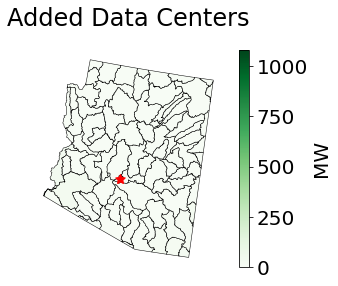

In [226]:
# Arizona
ax = visualize_stats(huc_subbasins_renewables_ignore[huc_subbasins_renewables_ignore['in_AZ']], 'add_DCs', 'Added Data Centers', 'Greens', r'MW', cmap_lims=[0, huc_subbasins_renewables_ignore['add_DCs'].max()], interest_point_list=[(33.4482, -112.0777)])

fig = ax.get_figure()

# fig.savefig("Figures/renewables_ignore_added_DCs_AZ.png", dpi=200, bbox_inches='tight')

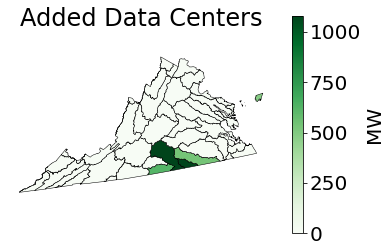

In [227]:
# Virginia
ax = visualize_stats(huc_subbasins_renewables_ignore[huc_subbasins_renewables_ignore['in_VA']], 'add_DCs', 'Added Data Centers', 'Greens', r'MW', cmap_lims=[0, huc_subbasins_renewables_ignore['add_DCs'].max()])

fig = ax.get_figure()

# fig.savefig("Figures/renewables_ignore_added_DCs_VA.png", dpi=200, bbox_inches='tight')

Text(0.5, 1.0, 'Complementarity of Total Wind and Solar Buildout')

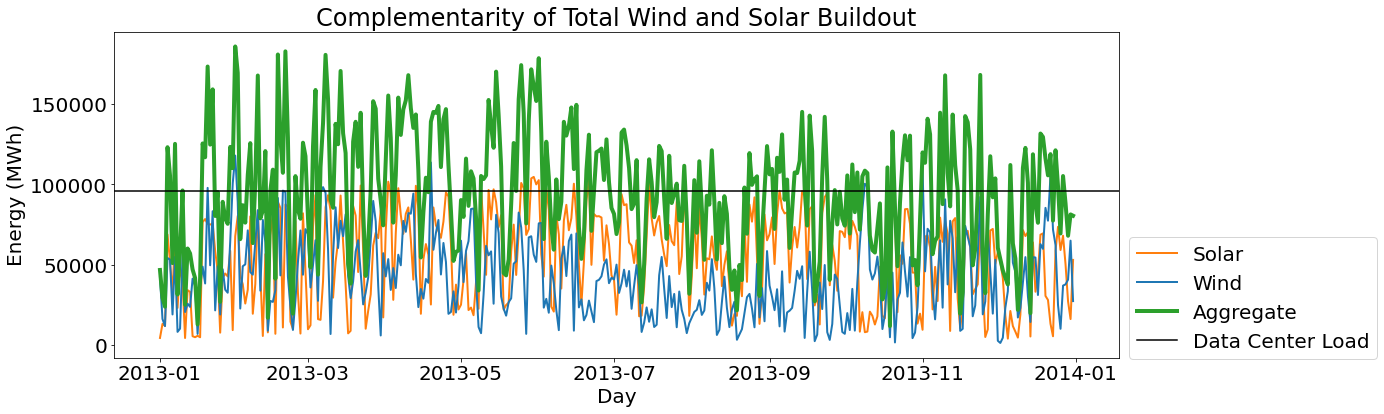

In [228]:
# check complementarity

# look at complementarity: wind and solar
fig, ax = plt.subplots(figsize=(18, 6))

solar_series = np.sum([(s[idx] * solar_gen[:, idx]) for idx in range(len(huc8_iter))], axis=0) 
wind_series = np.sum([(w[idx] * wind_gen[:, idx]) for idx in range(len(huc8_iter))], axis=0)

ax.plot(pd.date_range('2013-01-01', '2013-12-31'), solar_series, color="C1", linewidth=2, label="Solar")
ax.plot(pd.date_range('2013-01-01', '2013-12-31'), wind_series, color="C0", linewidth=2, label="Wind")

# plot the total now
ax.plot(pd.date_range('2013-01-01', '2013-12-31'), solar_series+wind_series, color="C2", linewidth=4, label="Aggregate")

ax.axhline((4000)*24, color="black", label="Data Center Load")

ax.set_xlabel("Day")
ax.set_ylabel("Energy (MWh)")

ax.legend(bbox_to_anchor=(1,0.4))

ax.set_title("Complementarity of Total Wind and Solar Buildout")

# fig.savefig("Figures/renewables_ignore_solar_wind_complementarity.png", dpi=200, bbox_inches='tight')

In [229]:
slope, intercept, rvalue, pvalue, _ = stats.linregress(solar_series, wind_series)

print(f"The estimated slope of solar versus wind data is {slope:.3f}, and the p-value from testing whether the slope is 0 is {pvalue:.3f}.")

The estimated slope of solar versus wind data is 0.012, and the p-value from testing whether the slope is 0 is 0.788.


Text(0.5, 1.0, 'Linear Regression of Wind and Solar Production')

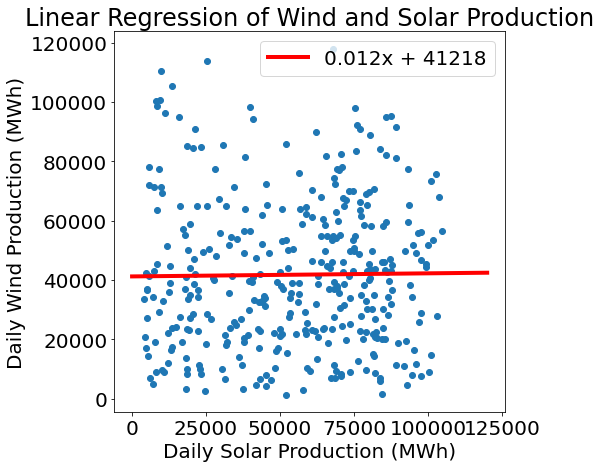

In [230]:
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(solar_series, wind_series)
ax.plot(np.linspace(0,120000), slope*np.linspace(0,100000)+intercept, color="red", linewidth=4, label=rf"{slope:.3f}x + {intercept:.0f}")

ax.set_xlabel("Daily Solar Production (MWh)")
ax.set_ylabel("Daily Wind Production (MWh)")

ax.legend()

ax.set_title("Linear Regression of Wind and Solar Production")

# fig.savefig("Figures/renewables_ignore_solar_wind_scatter.png", dpi=200, bbox_inches="tight")

In [ ]:
def get_water_stress(x, weights):
    """ Total water stress values """
    return np.sum([x[idx]*(weights['WSF_1MW_DC_normalize']*(huc_subbasins.loc[huc8_code, 'WSF_1MW_DC_normalize'])) for idx, huc8_code in enumerate(huc8_iter)])

In [ ]:
def get_carbon(x, weights):
    """ Total carbon values """
    return np.sum([x[idx]*(weights['CF_1MW_DC_normalize']*(huc_subbasins.loc[huc8_code, 'CF_1MW_DC_normalize'])) for idx, huc8_code in enumerate(huc8_iter)])

Water Stress Versus Emissions

In [246]:
pareto_frontier = [] # pareto frontier: (WSF/MW, CF/MW)

weight_history = [] # collect dictionaries of weights

weight_iter = [0.03, 0.06, 0.09]

for wsf_weight in weight_iter:
    for price_weight in weight_iter:
        for cf_weight in weight_iter:
            for basin_weight in weight_iter:
                
                curr_weights = {
                    'WSF_1MW_DC_normalize': wsf_weight,
                    'tot_price_normalize': price_weight,
                    'CF_1MW_DC_normalize': cf_weight,
                    'basin_max': basin_weight,
                    'deficit': 1 - wsf_weight - price_weight - cf_weight - basin_weight
                }

                x, s, w, basin_max, deficit = opt_add_dc(curr_weights, add_req=4000, existing=False, output=False)

                wsf_per_mw = np.sum([x[idx]*huc_subbasins.loc[huc8_code, 'WSF_1MW_DC'] for idx, huc8_code in enumerate(huc8_iter)])/4000
                # get_water_stress(x, curr_weights)/(wsf_weight*4000)
                cf_per_mw = np.sum([x[idx]*huc_subbasins.loc[huc8_code, 'CF_1MW_DC'] for idx, huc8_code in enumerate(huc8_iter)])/4000
                # get_carbon(x, curr_weights)/(cf_weight*4000)

                pareto_frontier.append((wsf_per_mw, cf_per_mw))

                weight_history.append(curr_weights)

In [248]:
# and then at the end collect the point for the existing MW
existing_wsf = np.sum(huc_subbasins['existing_M']*huc_subbasins['WSF_1MW_DC'])/np.sum(huc_subbasins['existing_M'])
existing_cf = np.sum(huc_subbasins['existing_M']*huc_subbasins['CF_1MW_DC'])/np.sum(huc_subbasins['existing_M'])

# pareto_frontier.append((existing_wsf, existing_cf))

In [250]:
huc_subbasins['CF_1MW_DC']

HUC8_x
15080200    0.194845
15080102    0.529667
15080101    0.529667
15080103    0.194845
15050306    0.529667
              ...   
02070010    0.436824
02070007    0.436824
02070003    0.436824
02070008    0.436824
02070004    0.436824
Name: CF_1MW_DC, Length: 132, dtype: float64

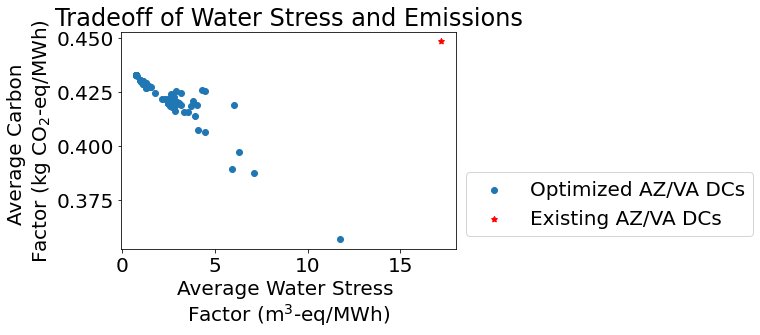

In [252]:
pareto_frontier_np = np.array(pareto_frontier)

fig, ax = plt.subplots()

ax.scatter(pareto_frontier_np[:,0], pareto_frontier_np[:,1], label="Optimized AZ/VA DCs")

# plot the pareto frontier


ax.set_xlabel("Average Water Stress \n" + r"Factor (m$^3$-eq/MWh)")
ax.set_ylabel("Average Carbon \n" + r"Factor (kg CO$_2$-eq/MWh)")

ax.set_title("Tradeoff of Water Stress and Emissions")

ax.scatter(existing_wsf, existing_cf, marker=(5,1), color="red", label="Existing AZ/VA DCs")

ax.legend(bbox_to_anchor=(1,0.4))


fig.savefig("Figures/ignore_tradeoff_vs_existing.png", dpi=200, bbox_inches="tight")

In [ ]:
def get_tot_price(x, weights):
    """ Total price values """
    return np.sum([x[huc8_code].X*(weights['tot_price']*(huc_subbasins.loc[huc8_code, 'tot_price'])) for huc8_code in huc8_iter])

In [ ]:
def get_basin_max(basin_max, weights):
    """ Basin value """
    return weights['basin_max']*basin_max.X/s_min

In [ ]:
def get_deficit(deficit, weights):
    """ Deficit value """
    
    return weights['deficit']*np.sum([deficit[day].X for day in range(365)])/(24*365)